In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.decomposition import PCA

plt.rcParams["figure.figsize"] = (8, 5)

In [5]:
#   1: LOAD DATA & BASIC INFO

print("===   LOAD DATA & BASIC INFO ===\n")

# Change this to your path if needed

df = pd.read_excel("online_course_recommendation_v2.xlsx")

print("Shape of raw data:", df.shape, "\n")

print("First 5 rows:")
print(df.head(), "\n")

print("Data types:")
print(df.dtypes, "\n")

print("Missing values per column:")
print(df.isnull().sum(), "\n")

print("Basic statistics (numeric):")
print(df.describe(), "\n")

print("Basic statistics (including object):")
print(df.describe(include='all'), "\n")

===   LOAD DATA & BASIC INFO ===

Shape of raw data: (100000, 14) 

First 5 rows:
   user_id  course_id                       course_name       instructor  \
0    15796       9366              Python for Beginners      Emma Harris   
1      861       1928   Cybersecurity for Professionals  Alexander Young   
2    38159       9541  DevOps and Continuous Deployment   Dr. Mia Walker   
3    44733       3708   Project Management Fundamentals   Benjamin Lewis   
4    11285       3361       Ethical Hacking Masterclass     Daniel White   

   course_duration_hours certification_offered difficulty_level  rating  \
0                   39.1                   Yes         Beginner     5.0   
1                   36.3                   Yes         Beginner     4.3   
2                   13.4                   Yes         Beginner     3.9   
3                   58.3                   Yes         Beginner     3.1   
4                   30.8                   Yes         Beginner     2.8   

   enrollm

In [6]:
#  2: DATA CLEANING / WRANGLING

print("\n===  2: DATA CLEANING / WRANGLING ===\n")

# 2.1 Strip whitespace for text columns
text_cols = [
    "course_name",
    "instructor",
    "difficulty_level",
    "certification_offered",
    "study_material_available",
]
for col in text_cols:
    df[col] = df[col].astype(str).str.strip()

print("Sample cleaned text values:")
print(df[text_cols].head(), "\n")

# 2.2 Convert Yes/No -> 1/0
yes_no_map = {"Yes": 1, "No": 0}
df["certification_offered_bin"] = df["certification_offered"].map(yes_no_map)
df["study_material_available_bin"] = df["study_material_available"].map(yes_no_map)

# 2.3 Map difficulty to ordinal
difficulty_map = {"Beginner": 1, "Intermediate": 2, "Advanced": 3}
df["difficulty_level_ord"] = df["difficulty_level"].map(difficulty_map)

print("After encoding Yes/No and difficulty:")
print(
    df[
        [
            "certification_offered",
            "certification_offered_bin",
            "study_material_available",
            "study_material_available_bin",
            "difficulty_level",
            "difficulty_level_ord",
        ]
    ].head(),
    "\n",
)

# 2.4 Check & remove duplicates based on user-course pair
dup_count = df.duplicated(subset=["user_id", "course_id"]).sum()
print("Number of duplicate (user_id, course_id) rows:", dup_count)

df = df.drop_duplicates(subset=["user_id", "course_id"])
print("Shape after dropping duplicates:", df.shape, "\n")

# 2.5 Handle missing values
numeric_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_all = df.select_dtypes(include=["object"]).columns.tolist()

# Fill numeric NaNs with median
for col in numeric_cols_all:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Filled NaNs in numeric column '{col}' with median = {median_val}")

# Fill categorical NaNs with mode
for col in cat_cols_all:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Filled NaNs in categorical column '{col}' with mode = {mode_val}")

print("\nMissing values AFTER cleaning:")
print(df.isnull().sum(), "\n")


===  2: DATA CLEANING / WRANGLING ===

Sample cleaned text values:
                        course_name       instructor difficulty_level  \
0              Python for Beginners      Emma Harris         Beginner   
1   Cybersecurity for Professionals  Alexander Young         Beginner   
2  DevOps and Continuous Deployment   Dr. Mia Walker         Beginner   
3   Project Management Fundamentals   Benjamin Lewis         Beginner   
4       Ethical Hacking Masterclass     Daniel White         Beginner   

  certification_offered study_material_available  
0                   Yes                      Yes  
1                   Yes                      Yes  
2                   Yes                      Yes  
3                   Yes                       No  
4                   Yes                      Yes   

After encoding Yes/No and difficulty:
  certification_offered  certification_offered_bin study_material_available  \
0                   Yes                          1                  

In [7]:
# 3: DATA TRANSFORMATION (SCALING)


print("\n=== 3: DATA TRANSFORMATION (SCALING) ===\n")

# Choose core numeric features for scaling (excluding IDs)
numeric_features_for_scaling = [
    "course_duration_hours",
    "rating",
    "enrollment_numbers",
    "course_price",
    "feedback_score",
    "time_spent_hours",
    "previous_courses_taken",
]

X_num = df[numeric_features_for_scaling].copy()

print("Numeric features to be scaled:")
print(X_num.head(), "\n")

# 3.1 StandardScaler (z-score)
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X_num)
df_std = pd.DataFrame(
    X_std, columns=[col + "_std" for col in numeric_features_for_scaling]
)

print("Standardized (z-score) sample:")
print(df_std.head(), "\n")

# 3.2 MinMaxScaler (0-1)
mm_scaler = MinMaxScaler()
X_mm = mm_scaler.fit_transform(X_num)
df_mm = pd.DataFrame(
    X_mm, columns=[col + "_minmax" for col in numeric_features_for_scaling]
)

print("MinMax-scaled (0-1) sample:")
print(df_mm.head(), "\n")

# 3.3 RobustScaler (robust to outliers)
rb_scaler = RobustScaler()
X_rb = rb_scaler.fit_transform(X_num)
df_rb = pd.DataFrame(
    X_rb, columns=[col + "_robust" for col in numeric_features_for_scaling]
)

print("Robust-scaled sample:")
print(df_rb.head(), "\n")

# 3.4 Log transform for skewed columns (e.g., enrollment_numbers, course_price)
df["enrollment_log"] = np.log1p(df["enrollment_numbers"])
df["course_price_log"] = np.log1p(df["course_price"])

print("Log-transformed features (enrollment_log, course_price_log):")
print(
    df[
        ["enrollment_numbers", "enrollment_log", "course_price", "course_price_log"]
    ].head(),
    "\n",
)



=== 3: DATA TRANSFORMATION (SCALING) ===

Numeric features to be scaled:
   course_duration_hours  rating  enrollment_numbers  course_price  \
0                   39.1     5.0               21600        317.50   
1                   36.3     4.3               15379         40.99   
2                   13.4     3.9                6431        380.81   
3                   58.3     3.1               48245        342.80   
4                   30.8     2.8               34556        381.01   

   feedback_score  time_spent_hours  previous_courses_taken  
0           0.797             17.60                       4  
1           0.770             28.97                       9  
2           0.772             52.44                       4  
3           0.969             22.29                       6  
4           0.555             22.01                       5   

Standardized (z-score) sample:
   course_duration_hours_std  rating_std  enrollment_numbers_std  \
0                  -0.484371    

In [8]:
#  4: FEATURE ENGINEERING


print("\n===  4: FEATURE ENGINEERING ===\n")

# 4.1 Price per hour
df["price_per_hour"] = df["course_price"] / df["course_duration_hours"]

# 4.2 Engagement ratio
df["engagement_ratio"] = df["time_spent_hours"] / df["course_duration_hours"]
df["engagement_ratio"] = df["engagement_ratio"].clip(upper=2.0)

# 4.3 Popularity score
df["popularity_score"] = df["enrollment_numbers"] * df["rating"]

# 4.4 Value for money
df["value_for_money"] = df["rating"] / df["course_price"]

# 4.5 Rating bucket (categorical)
df["rating_bucket"] = pd.cut(
    df["rating"],
    bins=[0, 2, 3.5, 4.5, 5.1],
    labels=["Low", "Okay", "Good", "Excellent"],
    include_lowest=True,
)

print("New engineered features sample:")
print(
    df[
        [
            "course_price",
            "course_duration_hours",
            "price_per_hour",
            "time_spent_hours",
            "engagement_ratio",
            "enrollment_numbers",
            "rating",
            "popularity_score",
            "value_for_money",
            "rating_bucket",
        ]
    ].head(),
    "\n",
)

# 4.6 Example of interaction feature
df["difficulty_rating_interaction"] = df["difficulty_level_ord"] * df["rating"]

print("Interaction feature sample (difficulty * rating):")
print(
    df[
        [
            "difficulty_level_ord",
            "rating",
            "difficulty_rating_interaction",
        ]
    ].head(),
    "\n",
)


===  4: FEATURE ENGINEERING ===

New engineered features sample:
   course_price  course_duration_hours  price_per_hour  time_spent_hours  \
0        317.50                   39.1        8.120205             17.60   
1         40.99                   36.3        1.129201             28.97   
2        380.81                   13.4       28.418657             52.44   
3        342.80                   58.3        5.879931             22.29   
4        381.01                   30.8       12.370455             22.01   

   engagement_ratio  enrollment_numbers  rating  popularity_score  \
0          0.450128               21600     5.0          108000.0   
1          0.798072               15379     4.3           66129.7   
2          2.000000                6431     3.9           25080.9   
3          0.382333               48245     3.1          149559.5   
4          0.714610               34556     2.8           96756.8   

   value_for_money rating_bucket  
0         0.015748     Exce


===  5: FEATURE SELECTION ===

Correlation matrix (top 5x5 block):
                       course_duration_hours    rating  enrollment_numbers  \
course_duration_hours               1.000000  0.001684           -0.000597   
rating                              0.001684  1.000000           -0.001137   
enrollment_numbers                 -0.000597 -0.001137            1.000000   
course_price                        0.002788 -0.001409            0.000454   
feedback_score                      0.001801  0.001523            0.001691   

                       course_price  feedback_score  
course_duration_hours      0.002788        0.001801  
rating                    -0.001409        0.001523  
enrollment_numbers         0.000454        0.001691  
course_price               1.000000        0.004092  
feedback_score             0.004092        1.000000   



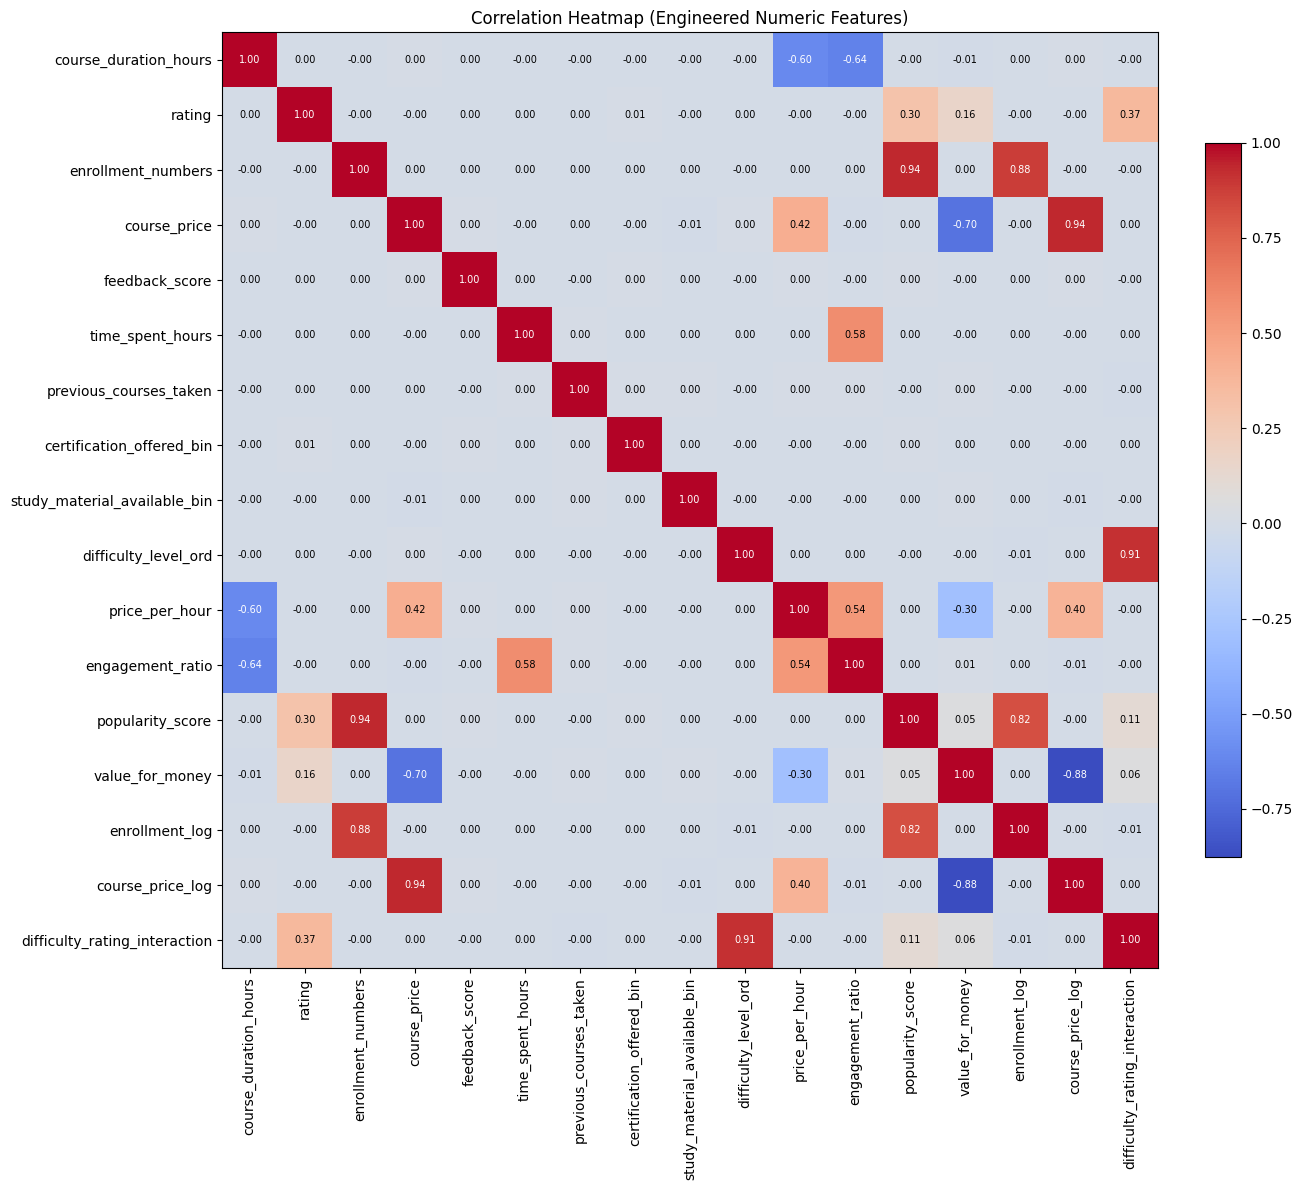

Features kept by VarianceThreshold:
['course_duration_hours', 'rating', 'enrollment_numbers', 'course_price', 'feedback_score', 'time_spent_hours', 'previous_courses_taken', 'certification_offered_bin', 'study_material_available_bin', 'difficulty_level_ord', 'price_per_hour', 'engagement_ratio', 'popularity_score', 'value_for_money', 'enrollment_log', 'course_price_log', 'difficulty_rating_interaction'] 

Top 10 features by SelectKBest (F-regression vs rating):
difficulty_rating_interaction: 15657.2560
popularity_score: 9880.7769
value_for_money: 2724.5881
certification_offered_bin: 8.4733
price_per_hour: 2.1839
engagement_ratio: 1.1363
enrollment_log: 0.9073
course_price_log: 0.5021
time_spent_hours: 0.4008
course_duration_hours: 0.2836

PCA Explained Variance Ratios (first 5 components):
PC1: 0.1750
PC2: 0.1635
PC3: 0.1265
PC4: 0.1169
PC5: 0.0678


In [9]:
# 5: FEATURE SELECTION (BASIC)

print("\n===  5: FEATURE SELECTION ===\n")

feature_cols_for_corr = [
    "course_duration_hours",
    "rating",
    "enrollment_numbers",
    "course_price",
    "feedback_score",
    "time_spent_hours",
    "previous_courses_taken",
    "certification_offered_bin",
    "study_material_available_bin",
    "difficulty_level_ord",
    "price_per_hour",
    "engagement_ratio",
    "popularity_score",
    "value_for_money",
    "enrollment_log",
    "course_price_log",
    "difficulty_rating_interaction",
]

# 5.1 Correlation matrix
corr = df[feature_cols_for_corr].corr()

print("Correlation matrix (top 5x5 block):")
print(corr.iloc[:5, :5], "\n")

# Correlation heatmap
plt.figure(figsize=(14, 12))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar(fraction=0.03, pad=0.04)
plt.xticks(range(len(feature_cols_for_corr)), feature_cols_for_corr, rotation=90)
plt.yticks(range(len(feature_cols_for_corr)), feature_cols_for_corr)
plt.title("Correlation Heatmap (Engineered Numeric Features)")

for i in range(len(feature_cols_for_corr)):
    for j in range(len(feature_cols_for_corr)):
        value = corr.values[i, j]
        color = "white" if abs(value) > 0.6 else "black"
        plt.text(j, i, f"{value:.2f}", ha="center", va="center", fontsize=7, color=color)

plt.tight_layout()
plt.show()

# 5.2 Variance Threshold
numeric_for_fs = df[feature_cols_for_corr].copy()

vt = VarianceThreshold(threshold=0.0)
vt.fit(numeric_for_fs)
support_mask = vt.get_support()

selected_by_variance = [col for col, keep in zip(feature_cols_for_corr, support_mask) if keep]
print("Features kept by VarianceThreshold:")
print(selected_by_variance, "\n")

# 5.3 SelectKBest (F-regression vs rating)
X_fs = numeric_for_fs.drop(columns=["rating"])
y_fs = df["rating"]

skb = SelectKBest(score_func=f_regression, k=10)
skb.fit(X_fs, y_fs)

scores = skb.scores_
kbest_features = sorted(
    zip(X_fs.columns, scores),
    key=lambda x: x[1],
    reverse=True
)[:10]

print("Top 10 features by SelectKBest (F-regression vs rating):")
for name, score in kbest_features:
    print(f"{name}: {score:.4f}")

# 5.4 PCA (first 5 components)
scaler_pca = StandardScaler()
X_for_pca = scaler_pca.fit_transform(numeric_for_fs)

pca = PCA(n_components=5, random_state=42)
pca.fit(X_for_pca)

print("\nPCA Explained Variance Ratios (first 5 components):")
for i, var in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"PC{i}: {var:.4f}")

In [10]:

# 6: EXPLORATORY DATA ANALYSIS (EDA)



=== PHASE 5B: EXPLORATORY DATA ANALYSIS (EDA) ===



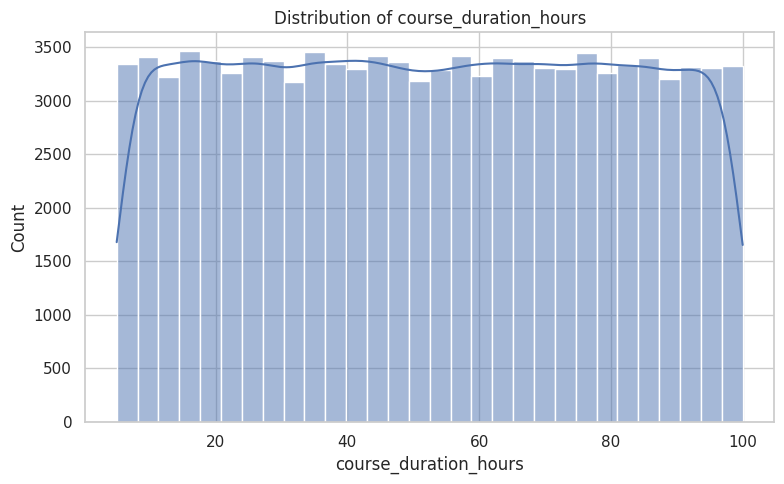

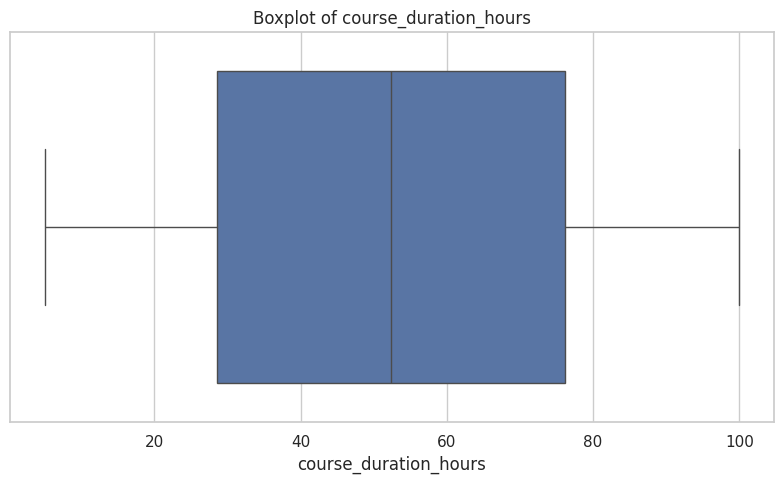

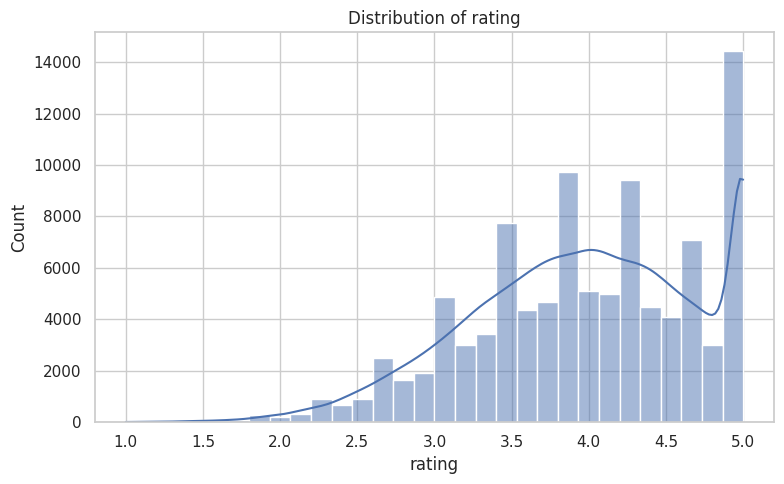

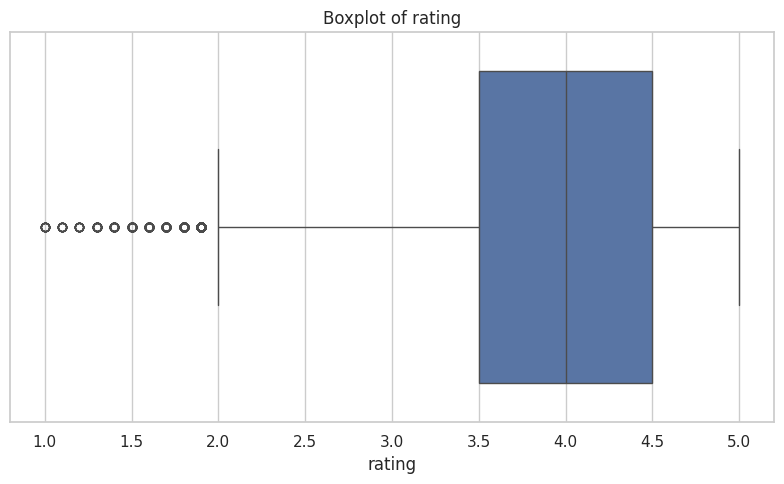

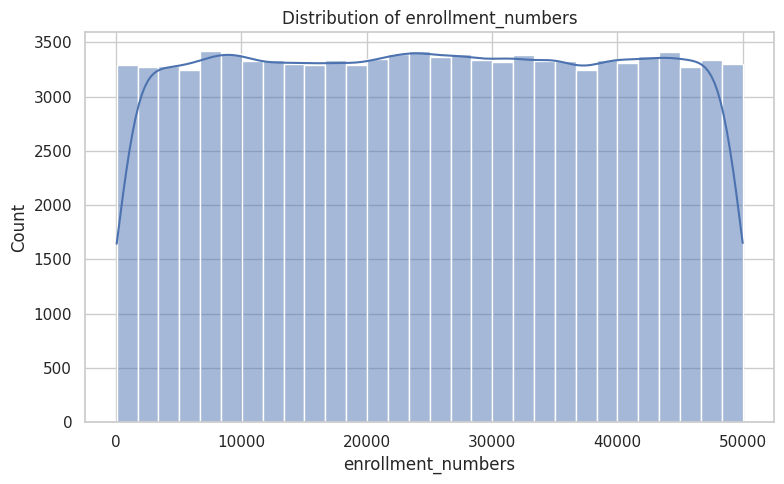

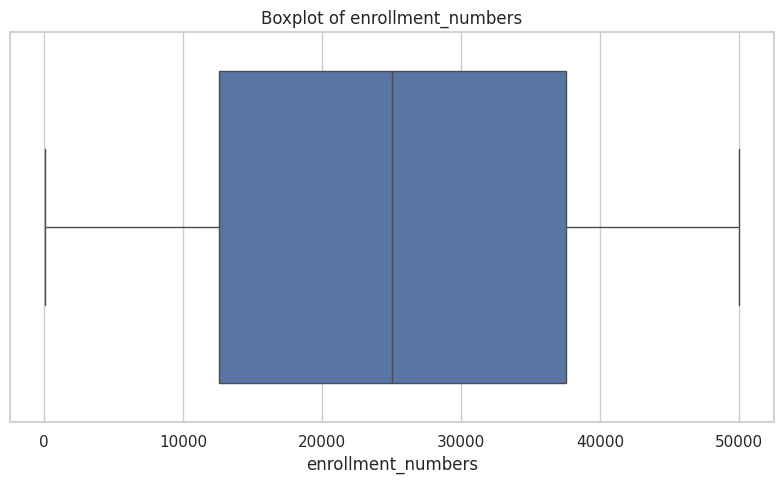

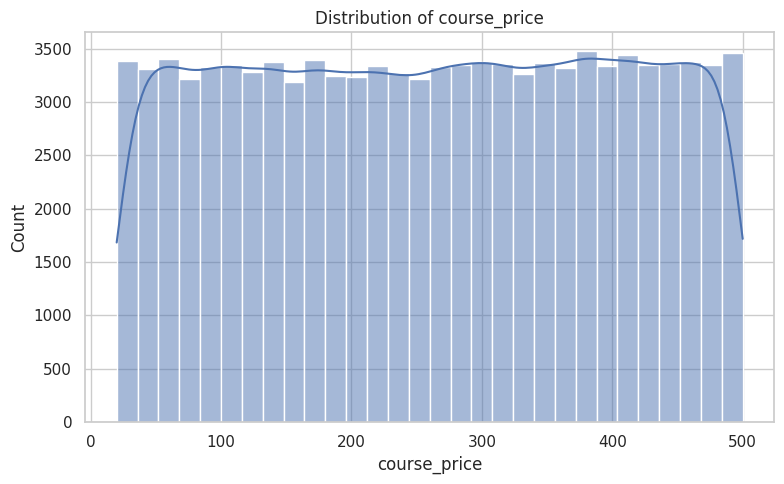

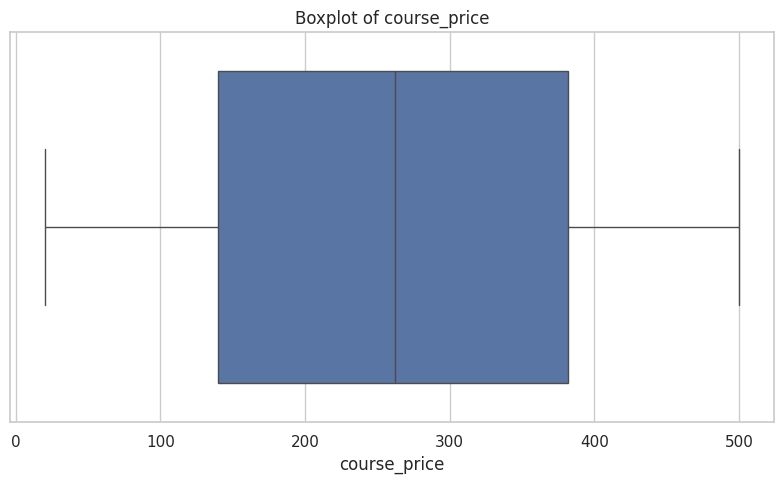

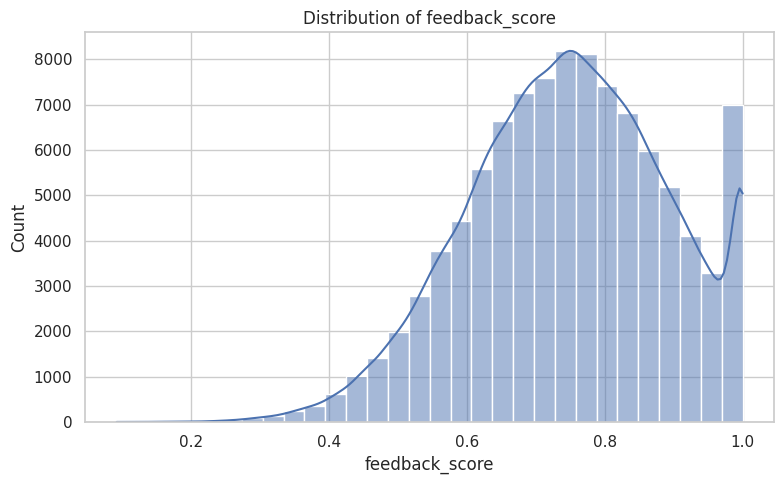

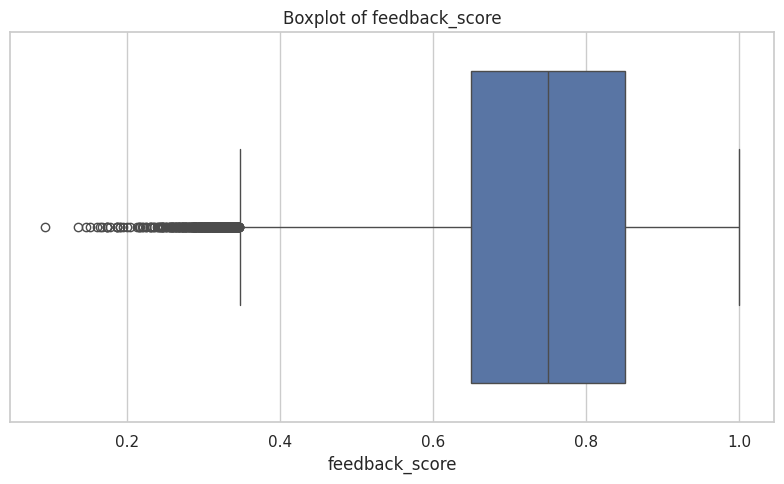

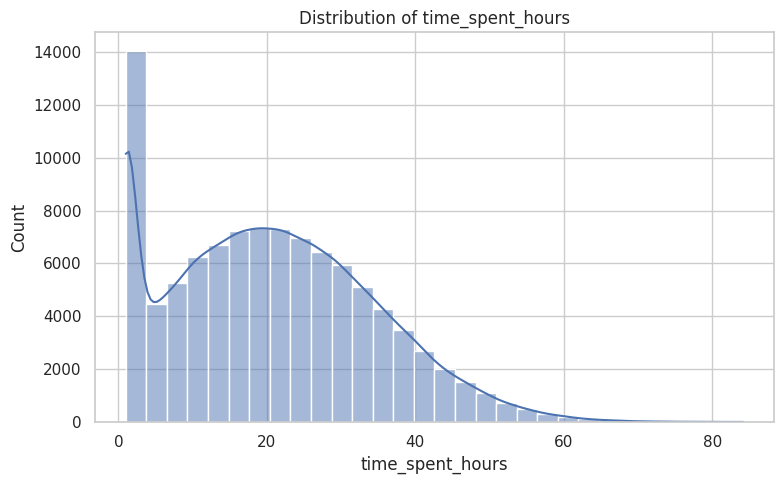

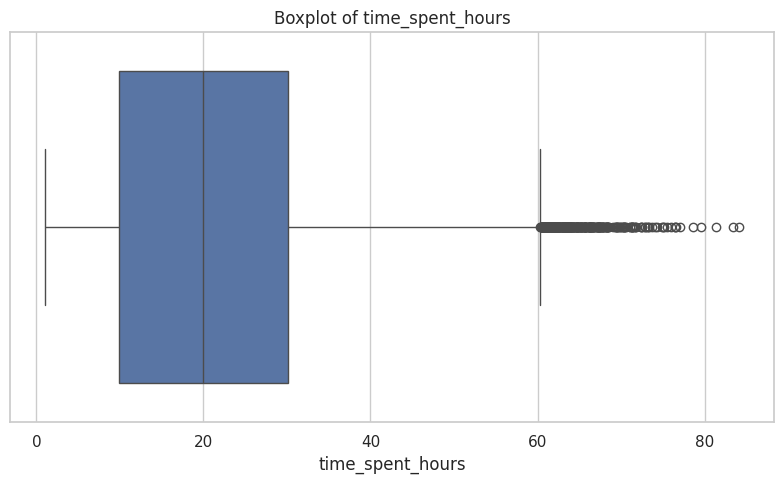

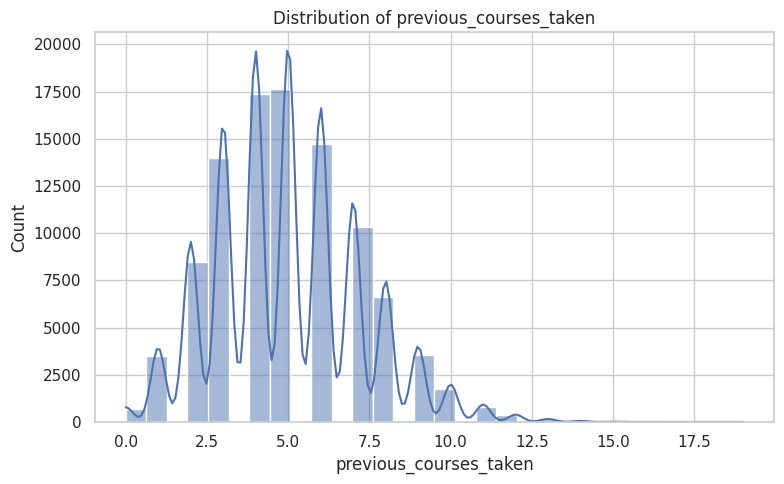

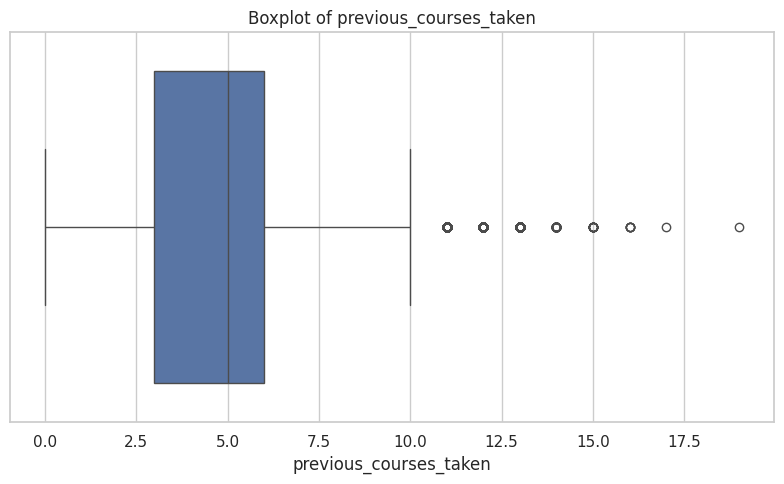

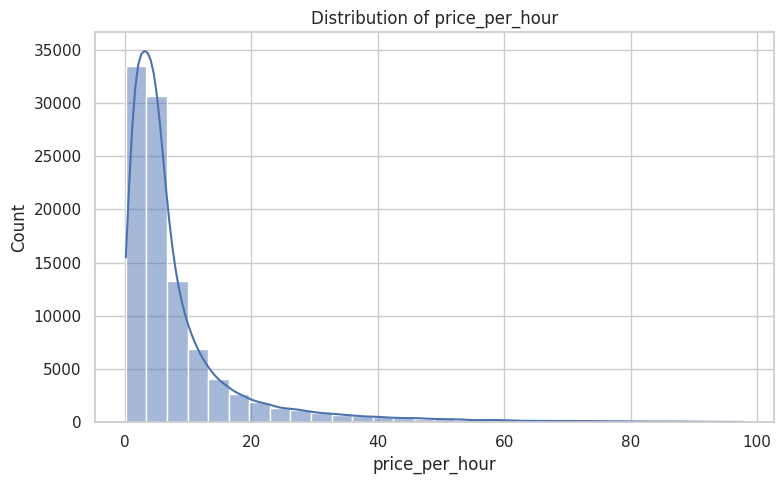

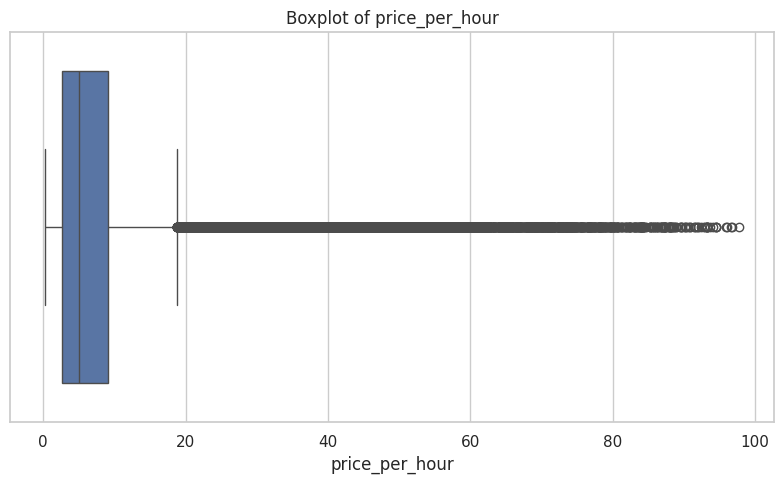

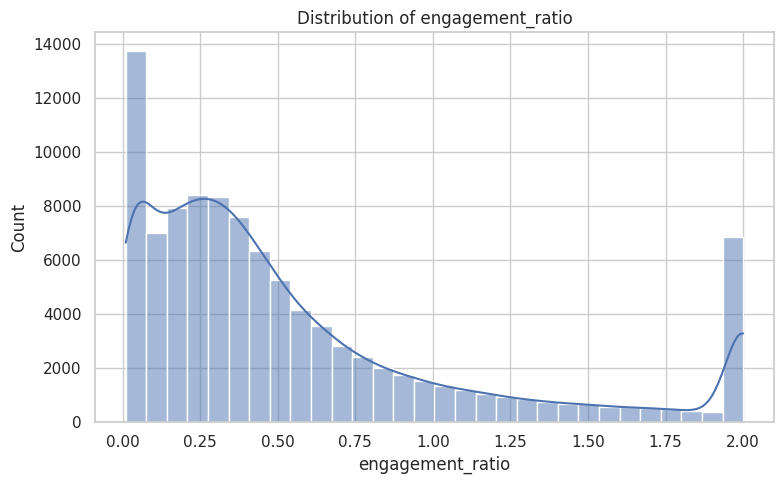

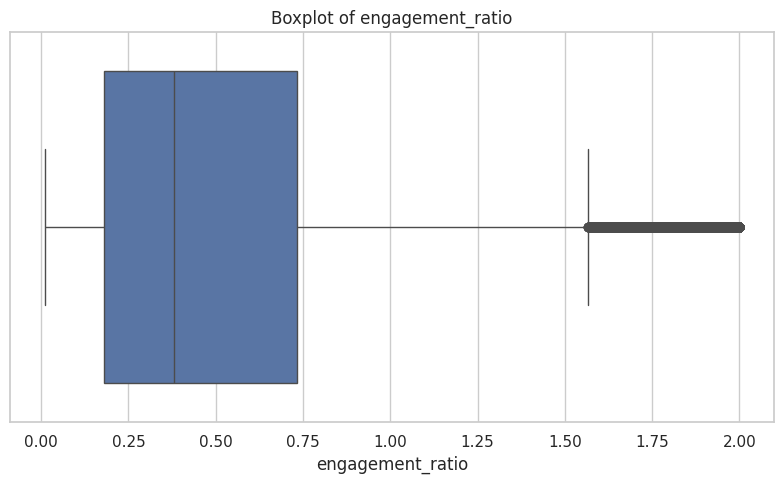

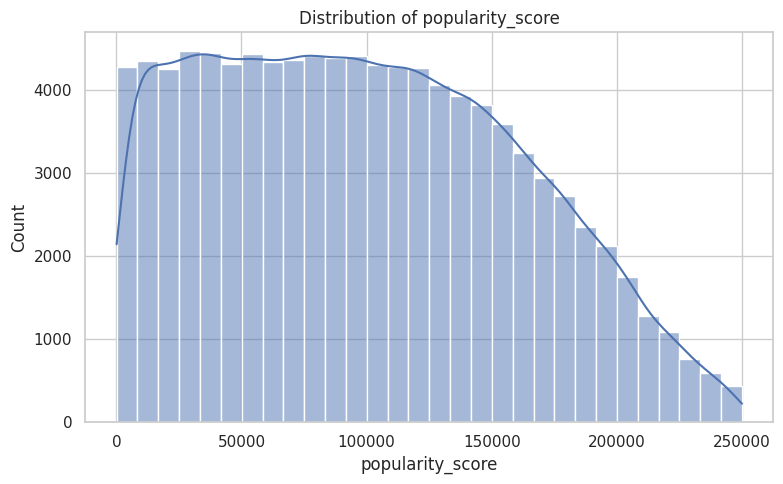

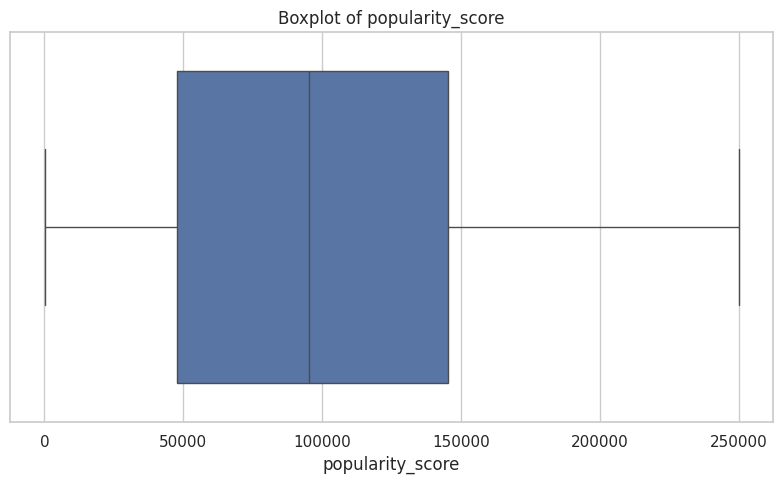

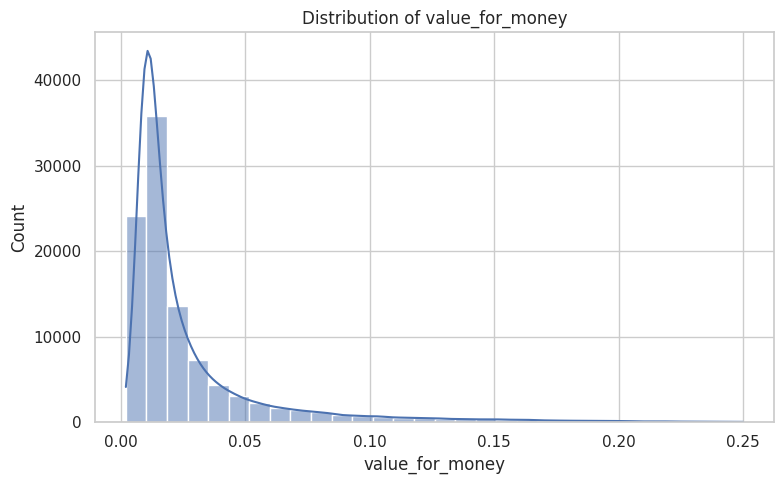

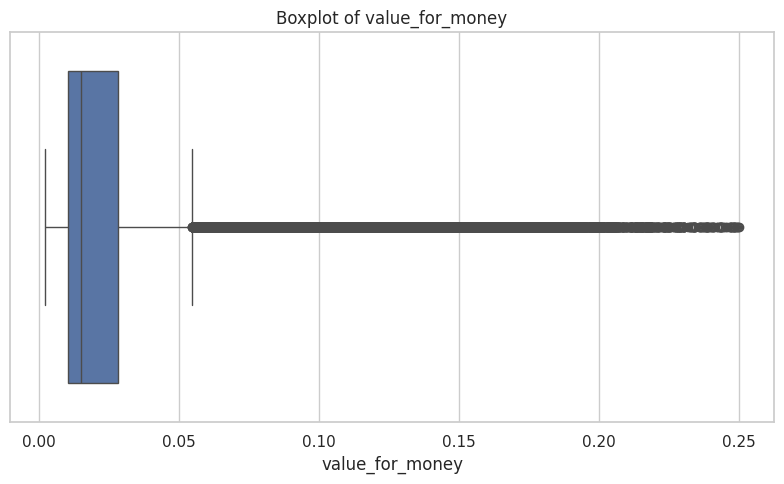

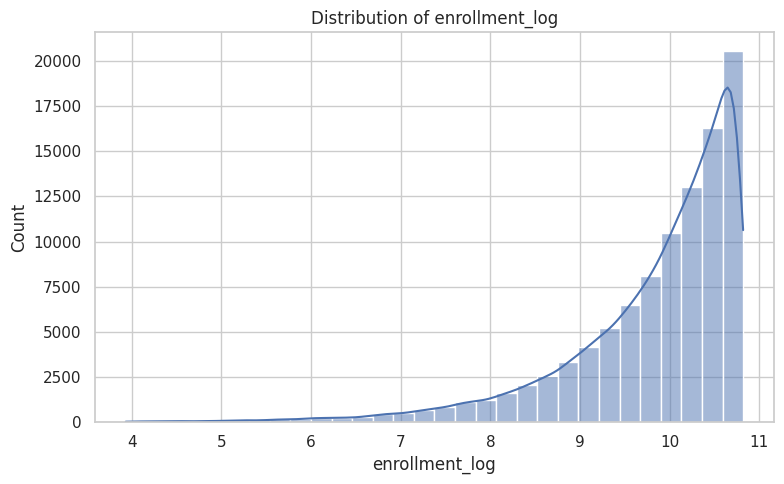

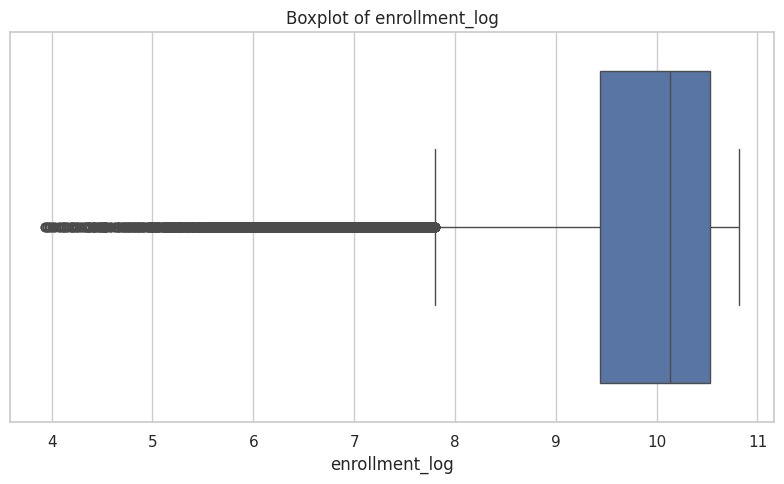

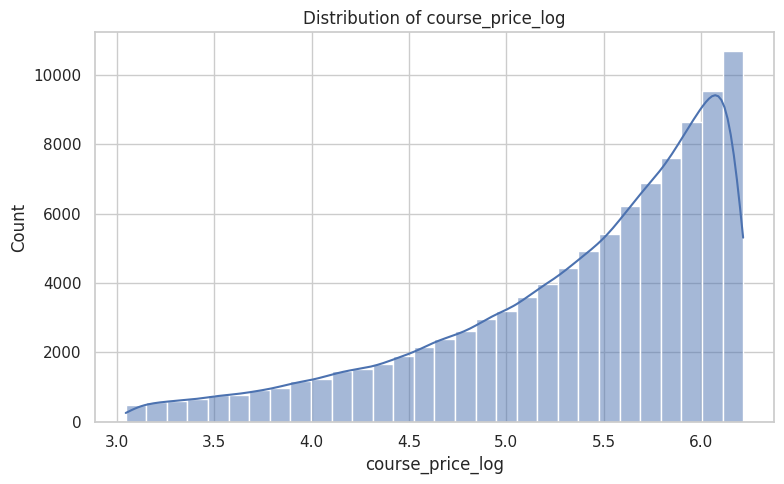

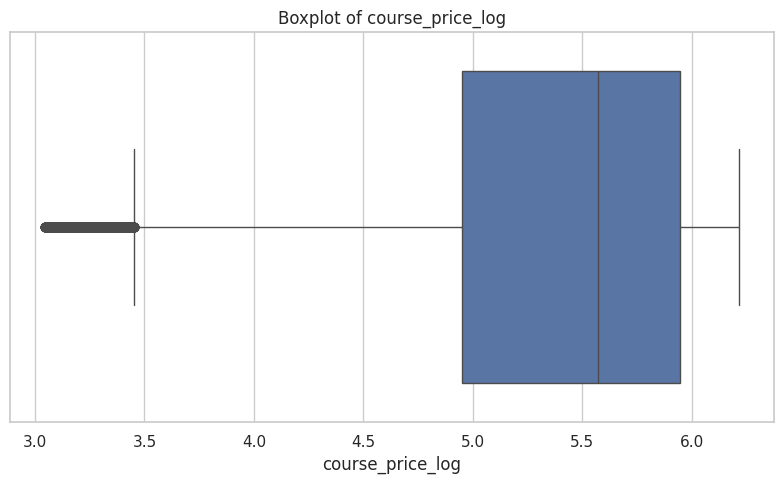

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

print("\n=== PHASE 5B: EXPLORATORY DATA ANALYSIS (EDA) ===\n")


#  . UNIVARIATE ANALYSIS - NUMERIC FEATURES


numeric_cols = [
    "course_duration_hours", "rating", "enrollment_numbers", "course_price",
    "feedback_score", "time_spent_hours", "previous_courses_taken",
    "price_per_hour", "engagement_ratio", "popularity_score",
    "value_for_money", "enrollment_log", "course_price_log"
]

for col in numeric_cols:
    plt.figure()
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

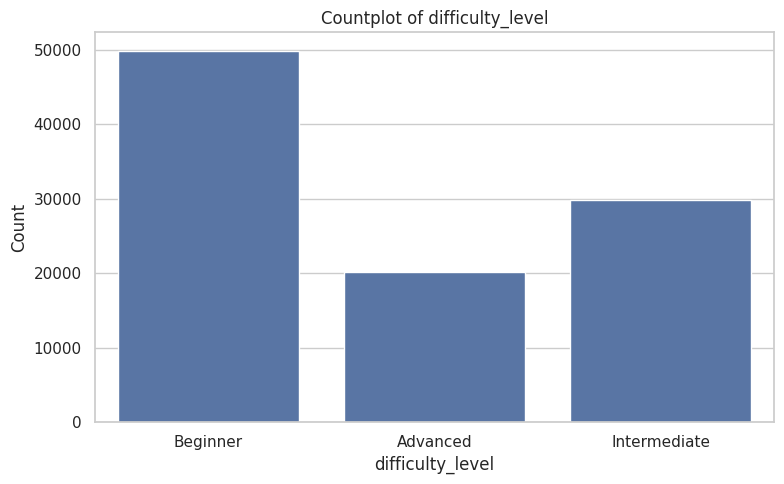

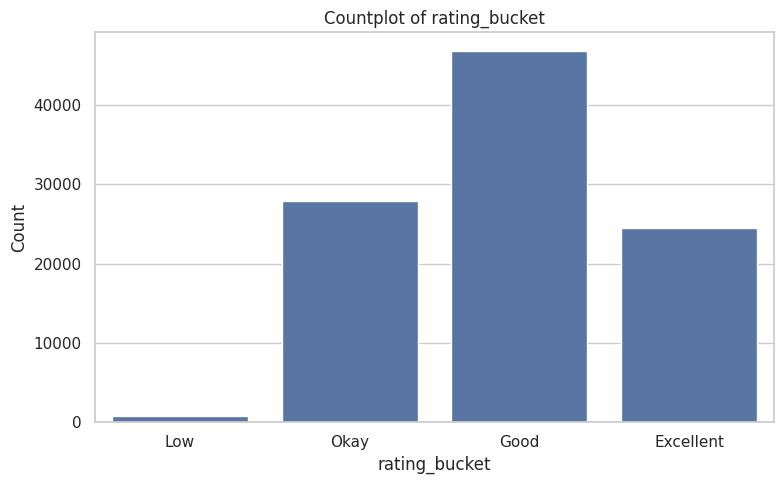

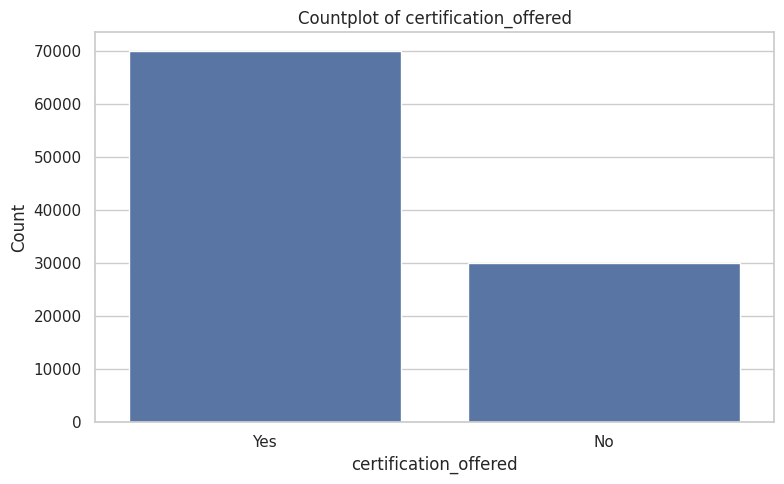

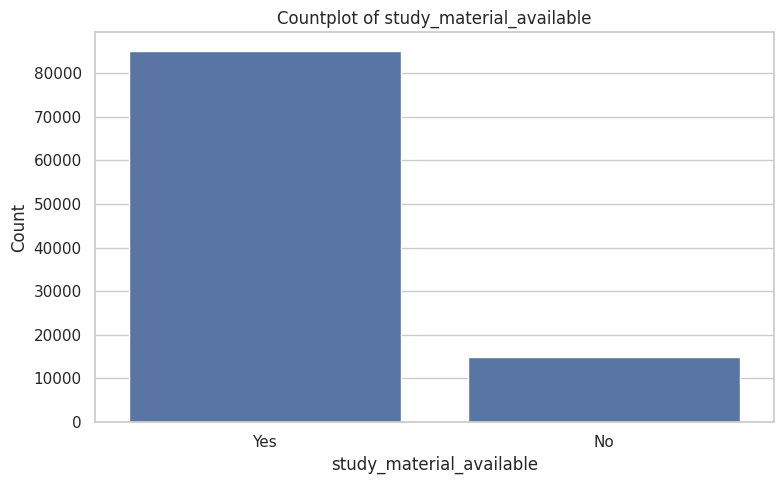

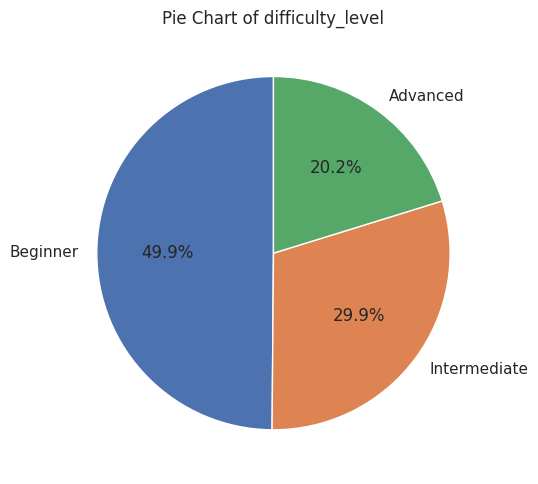

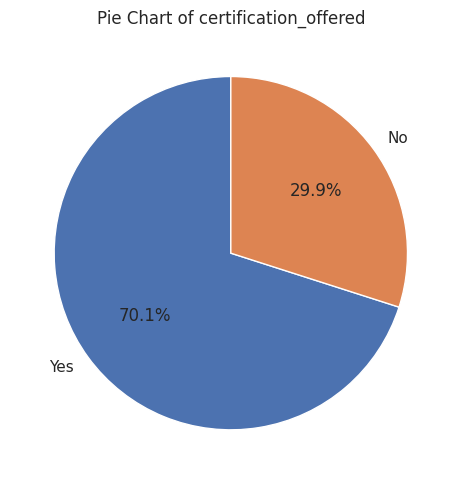

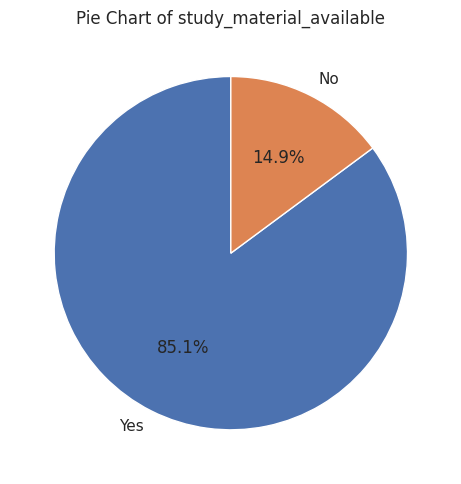

In [12]:
#   UNIVARIATE ANALYSIS - CATEGORICAL FEATURES

cat_cols = ["difficulty_level", "rating_bucket", "certification_offered",
            "study_material_available"]

for col in cat_cols:
    plt.figure()
    sns.countplot(x=df[col])
    plt.title(f"Countplot of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Pie charts for some categorical variables
for col in ["difficulty_level", "certification_offered", "study_material_available"]:
    plt.figure()
    df[col].value_counts().plot(kind="pie", autopct="%1.1f%%", startangle=90)
    plt.title(f"Pie Chart of {col}")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

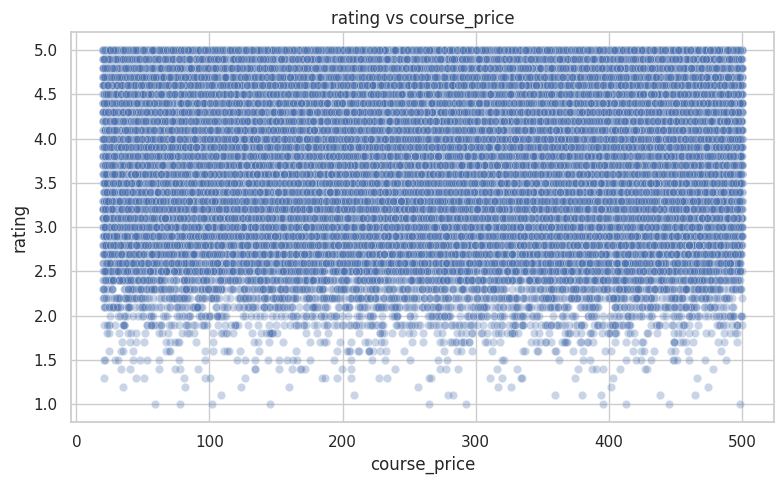

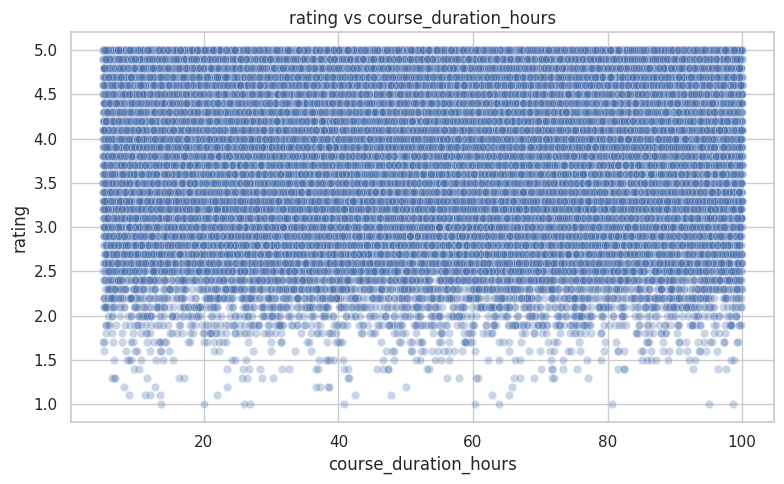

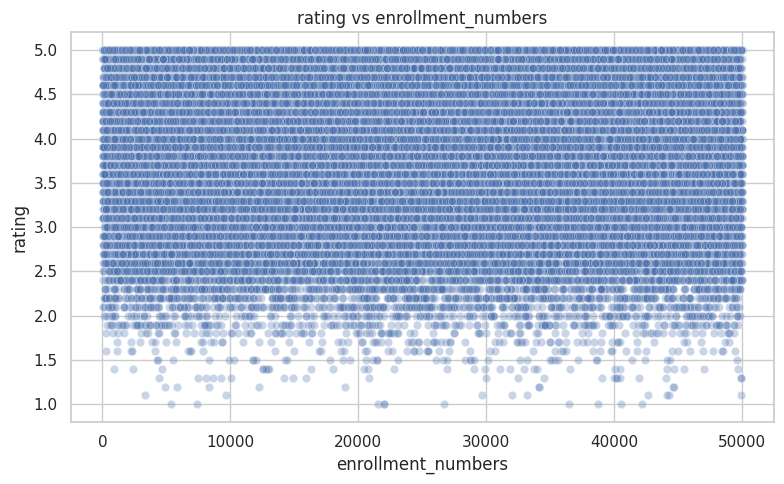

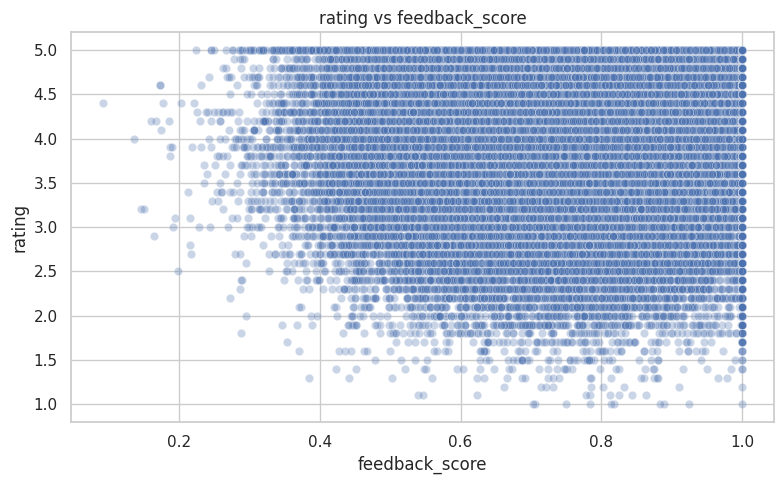

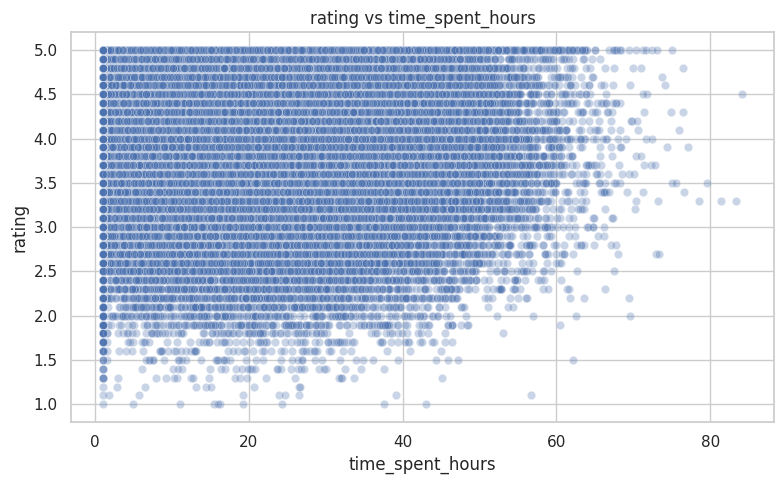

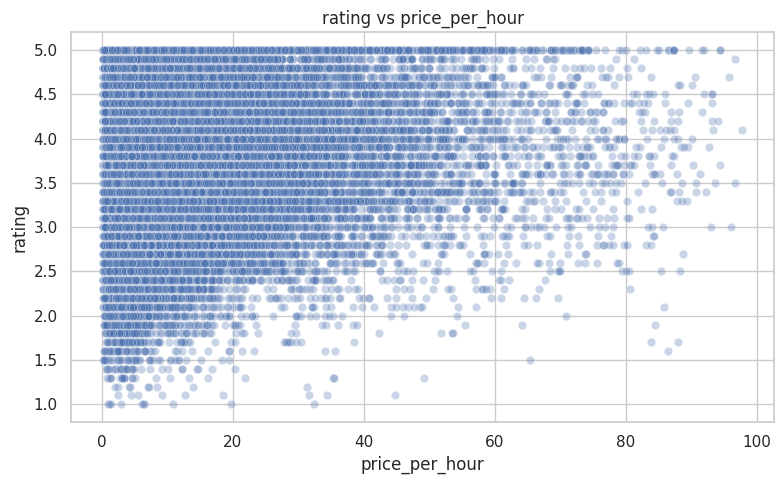

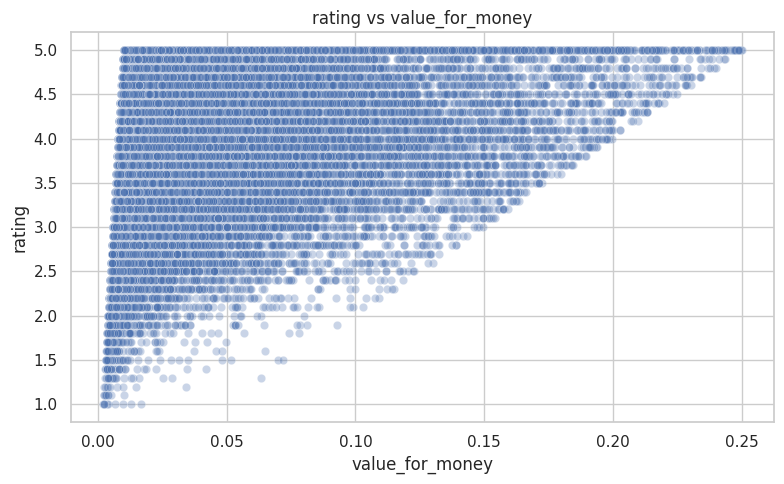

In [13]:
#   BIVARIATE ANALYSIS - NUMERIC vs NUMERIC

# Scatter plots: rating vs key numeric features
num_pairs = [
    ("course_price", "rating"),
    ("course_duration_hours", "rating"),
    ("enrollment_numbers", "rating"),
    ("feedback_score", "rating"),
    ("time_spent_hours", "rating"),
    ("price_per_hour", "rating"),
    ("value_for_money", "rating")
]

for x_col, y_col in num_pairs:
    plt.figure()
    sns.scatterplot(data=df, x=x_col, y=y_col, alpha=0.3)
    plt.title(f"{y_col} vs {x_col}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()

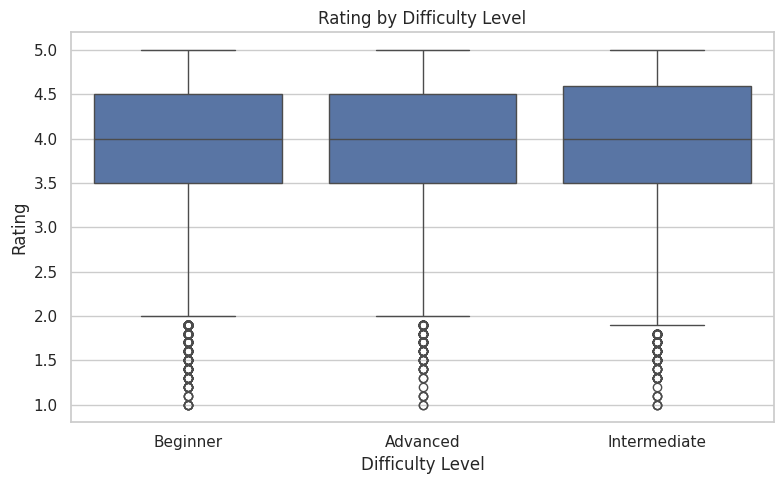

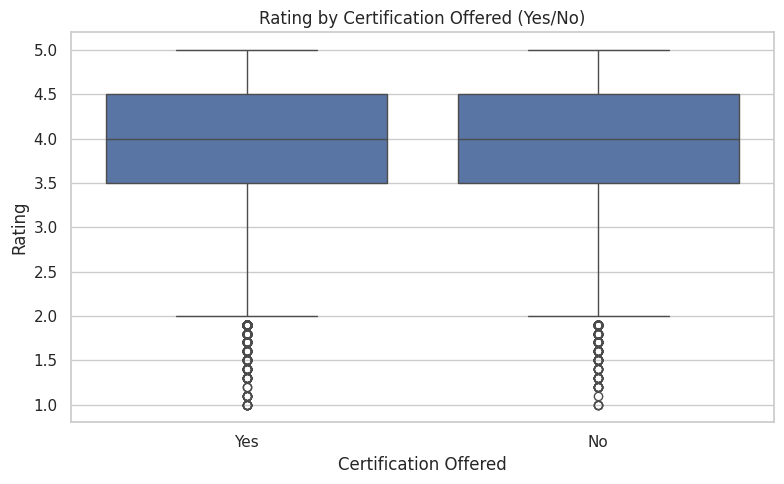

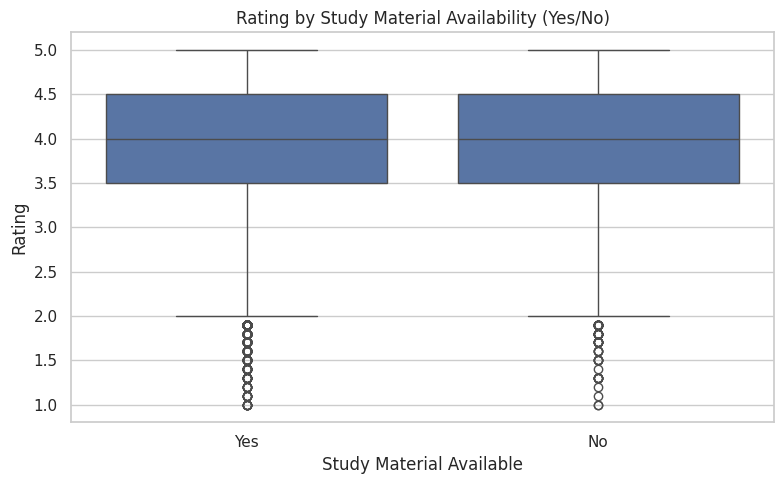

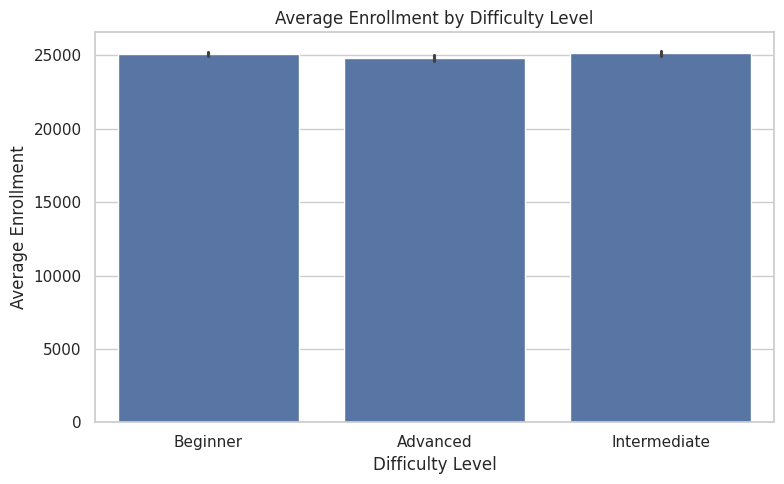

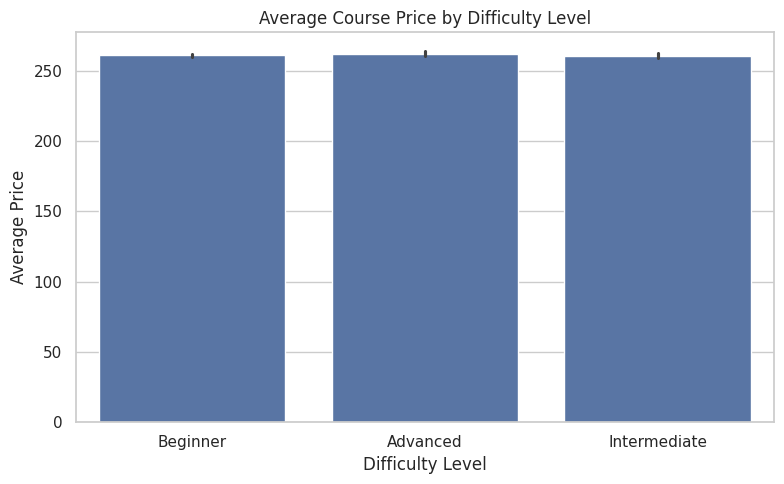

In [14]:
# . BIVARIATE ANALYSIS - NUMERIC vs CATEGORICAL
# Boxplots of rating by difficulty, certification, study material
plt.figure()
sns.boxplot(data=df, x="difficulty_level", y="rating")
plt.title("Rating by Difficulty Level")
plt.xlabel("Difficulty Level")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()

plt.figure()
sns.boxplot(data=df, x="certification_offered", y="rating")
plt.title("Rating by Certification Offered (Yes/No)")
plt.xlabel("Certification Offered")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()

plt.figure()
sns.boxplot(data=df, x="study_material_available", y="rating")
plt.title("Rating by Study Material Availability (Yes/No)")
plt.xlabel("Study Material Available")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()

# Enrollment by difficulty (barplot)
plt.figure()
sns.barplot(data=df, x="difficulty_level", y="enrollment_numbers", estimator=np.mean)
plt.title("Average Enrollment by Difficulty Level")
plt.xlabel("Difficulty Level")
plt.ylabel("Average Enrollment")
plt.tight_layout()
plt.show()

# Price by difficulty
plt.figure()
sns.barplot(data=df, x="difficulty_level", y="course_price", estimator=np.mean)
plt.title("Average Course Price by Difficulty Level")
plt.xlabel("Difficulty Level")
plt.ylabel("Average Price")
plt.tight_layout()
plt.show()

In [15]:
# OUTLIERS  DETECTION

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower) | (df[column] > upper)][column]

    print(f"\nColumn: {column}")
    print(f"Lower Bound: {lower:.4f} | Upper Bound: {upper:.4f}")
    print(f"Outliers Count: {outliers.count()}")
    print(f"Outliers %: {(outliers.count() / len(df) * 100):.2f}%")

    return outliers

In [16]:
# DETECT OUTLIERS BEFORE CLEANING

num_cols = [
    "rating", "feedback_score", "time_spent_hours", "previous_courses_taken",
    "price_per_hour", "engagement_ratio", "value_for_money",
    "enrollment_numbers", "course_price"
]

print("=== OUTLIERS BEFORE CLEANING ===")
for col in num_cols:
    detect_outliers_iqr(df, col)

=== OUTLIERS BEFORE CLEANING ===

Column: rating
Lower Bound: 2.0000 | Upper Bound: 6.0000
Outliers Count: 529
Outliers %: 0.53%

Column: feedback_score
Lower Bound: 0.3460 | Upper Bound: 1.1540
Outliers Count: 377
Outliers %: 0.38%

Column: time_spent_hours
Lower Bound: -20.3700 | Upper Bound: 60.3500
Outliers Count: 342
Outliers %: 0.34%

Column: previous_courses_taken
Lower Bound: -1.5000 | Upper Bound: 10.5000
Outliers Count: 1373
Outliers %: 1.37%

Column: price_per_hour
Lower Bound: -7.0266 | Upper Bound: 18.8481
Outliers Count: 9646
Outliers %: 9.65%

Column: engagement_ratio
Lower Bound: -0.6547 | Upper Bound: 1.5674
Outliers Count: 9433
Outliers %: 9.43%

Column: value_for_money
Lower Bound: -0.0163 | Upper Bound: 0.0548
Outliers Count: 10974
Outliers %: 10.97%

Column: enrollment_numbers
Lower Bound: -24822.7500 | Upper Bound: 74927.2500
Outliers Count: 0
Outliers %: 0.00%

Column: course_price
Lower Bound: -222.3150 | Upper Bound: 744.1250
Outliers Count: 0
Outliers %: 0.00%

In [17]:
#   OUTLIER CAPPING FUNCTION (WINSORIZATION)

def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Winsorization (capping)
    df[column] = df[column].clip(lower=lower, upper=upper)
    return df

In [18]:
#   APPLY OUTLIER CAPPING TO ALL SELECTED COLUMNS

df_clean = df.copy()   # keep original safe

for col in num_cols:
    df_clean = cap_outliers_iqr(df_clean, col)


In [19]:
#   DETECT OUTLIERS AGAIN (AFTER CLEANING)
print("\n=== OUTLIERS AFTER CLEANING ===")
for col in num_cols:
    detect_outliers_iqr(df_clean, col)



=== OUTLIERS AFTER CLEANING ===

Column: rating
Lower Bound: 2.0000 | Upper Bound: 6.0000
Outliers Count: 0
Outliers %: 0.00%

Column: feedback_score
Lower Bound: 0.3460 | Upper Bound: 1.1540
Outliers Count: 0
Outliers %: 0.00%

Column: time_spent_hours
Lower Bound: -20.3700 | Upper Bound: 60.3500
Outliers Count: 0
Outliers %: 0.00%

Column: previous_courses_taken
Lower Bound: -1.5000 | Upper Bound: 10.5000
Outliers Count: 0
Outliers %: 0.00%

Column: price_per_hour
Lower Bound: -7.0266 | Upper Bound: 18.8481
Outliers Count: 0
Outliers %: 0.00%

Column: engagement_ratio
Lower Bound: -0.6547 | Upper Bound: 1.5674
Outliers Count: 0
Outliers %: 0.00%

Column: value_for_money
Lower Bound: -0.0163 | Upper Bound: 0.0548
Outliers Count: 0
Outliers %: 0.00%

Column: enrollment_numbers
Lower Bound: -24822.7500 | Upper Bound: 74927.2500
Outliers Count: 0
Outliers %: 0.00%

Column: course_price
Lower Bound: -222.3150 | Upper Bound: 744.1250
Outliers Count: 0
Outliers %: 0.00%


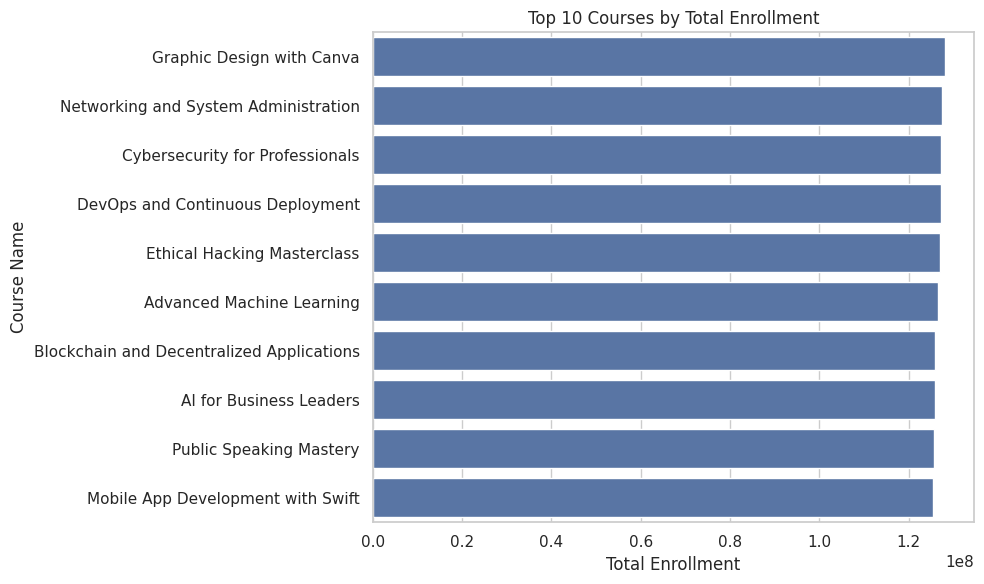

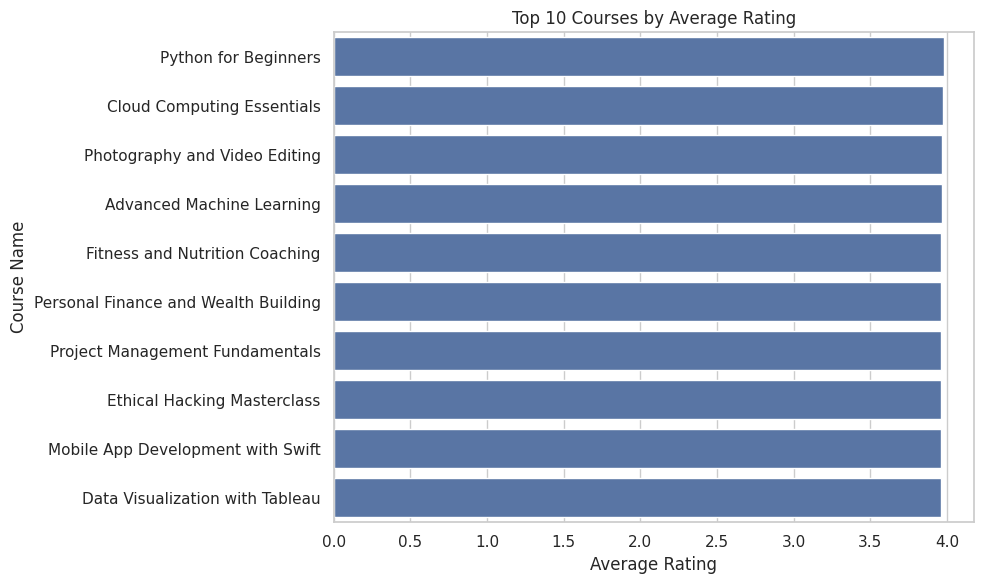

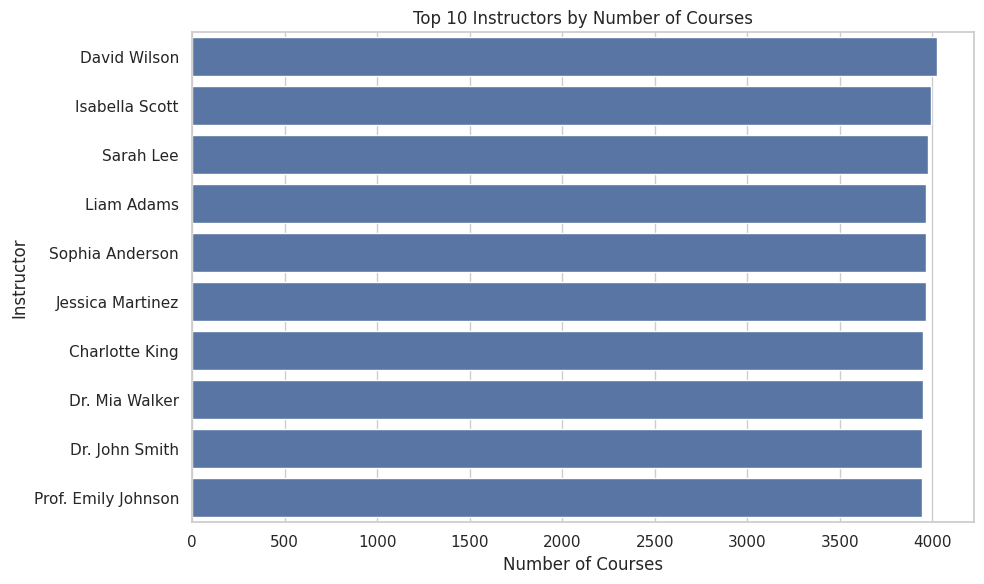

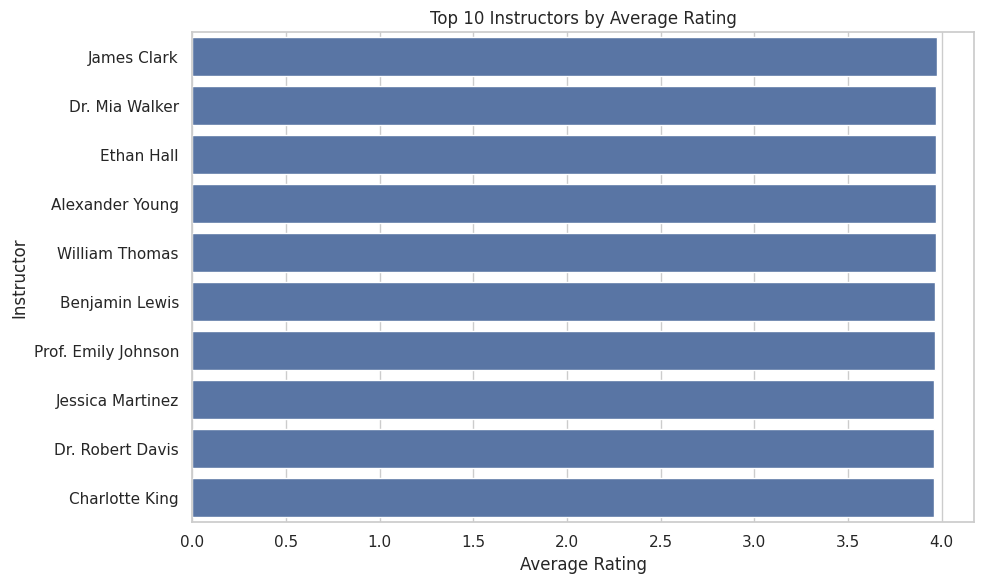

In [20]:
#  TOP COURSES / INSTRUCTORS – COMPARISON BAR CHARTS

# Top 10 courses by total enrollment
top_courses_enrollment = (
    df.groupby("course_name")["enrollment_numbers"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_courses_enrollment.values,
            y=top_courses_enrollment.index)
plt.title("Top 10 Courses by Total Enrollment")
plt.xlabel("Total Enrollment")
plt.ylabel("Course Name")
plt.tight_layout()
plt.show()

# Top 10 courses by average rating
top_courses_rating = (
    df.groupby("course_name")["rating"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_courses_rating.values,
            y=top_courses_rating.index)
plt.title("Top 10 Courses by Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Course Name")
plt.tight_layout()
plt.show()

# Top 10 instructors by number of courses
top_instructors_courses = (
    df.groupby("instructor")["course_id"]
      .nunique()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_instructors_courses.values,
            y=top_instructors_courses.index)
plt.title("Top 10 Instructors by Number of Courses")
plt.xlabel("Number of Courses")
plt.ylabel("Instructor")
plt.tight_layout()
plt.show()

# Top 10 instructors by average rating
top_instructors_rating = (
    df.groupby("instructor")["rating"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_instructors_rating.values,
            y=top_instructors_rating.index)
plt.title("Top 10 Instructors by Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Instructor")
plt.tight_layout()
plt.show()

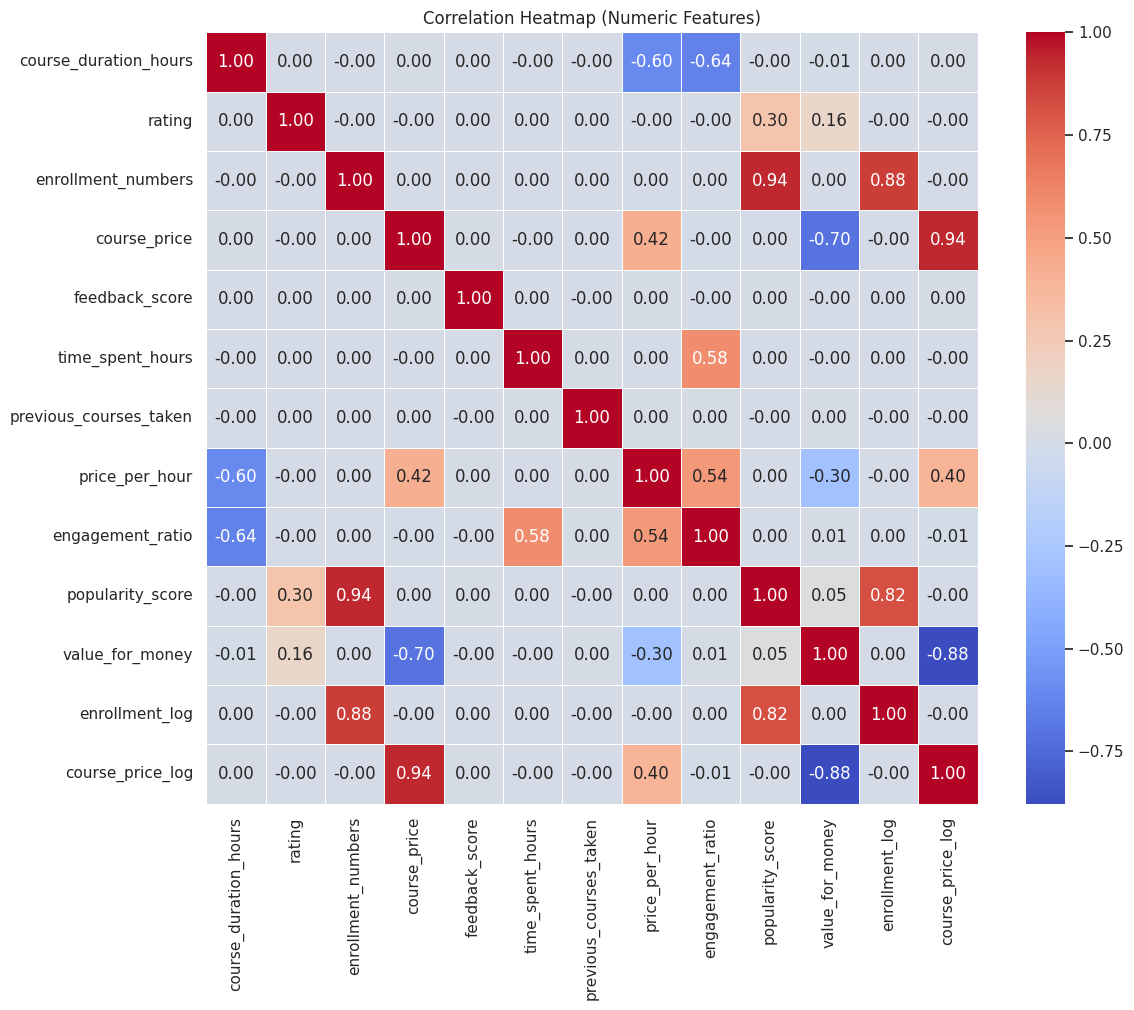

In [21]:
# 6. CORRELATION HEATMAP (SEABORN VERSION)

plt.figure(figsize=(12, 10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm",
            linewidths=0.5, square=True)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()

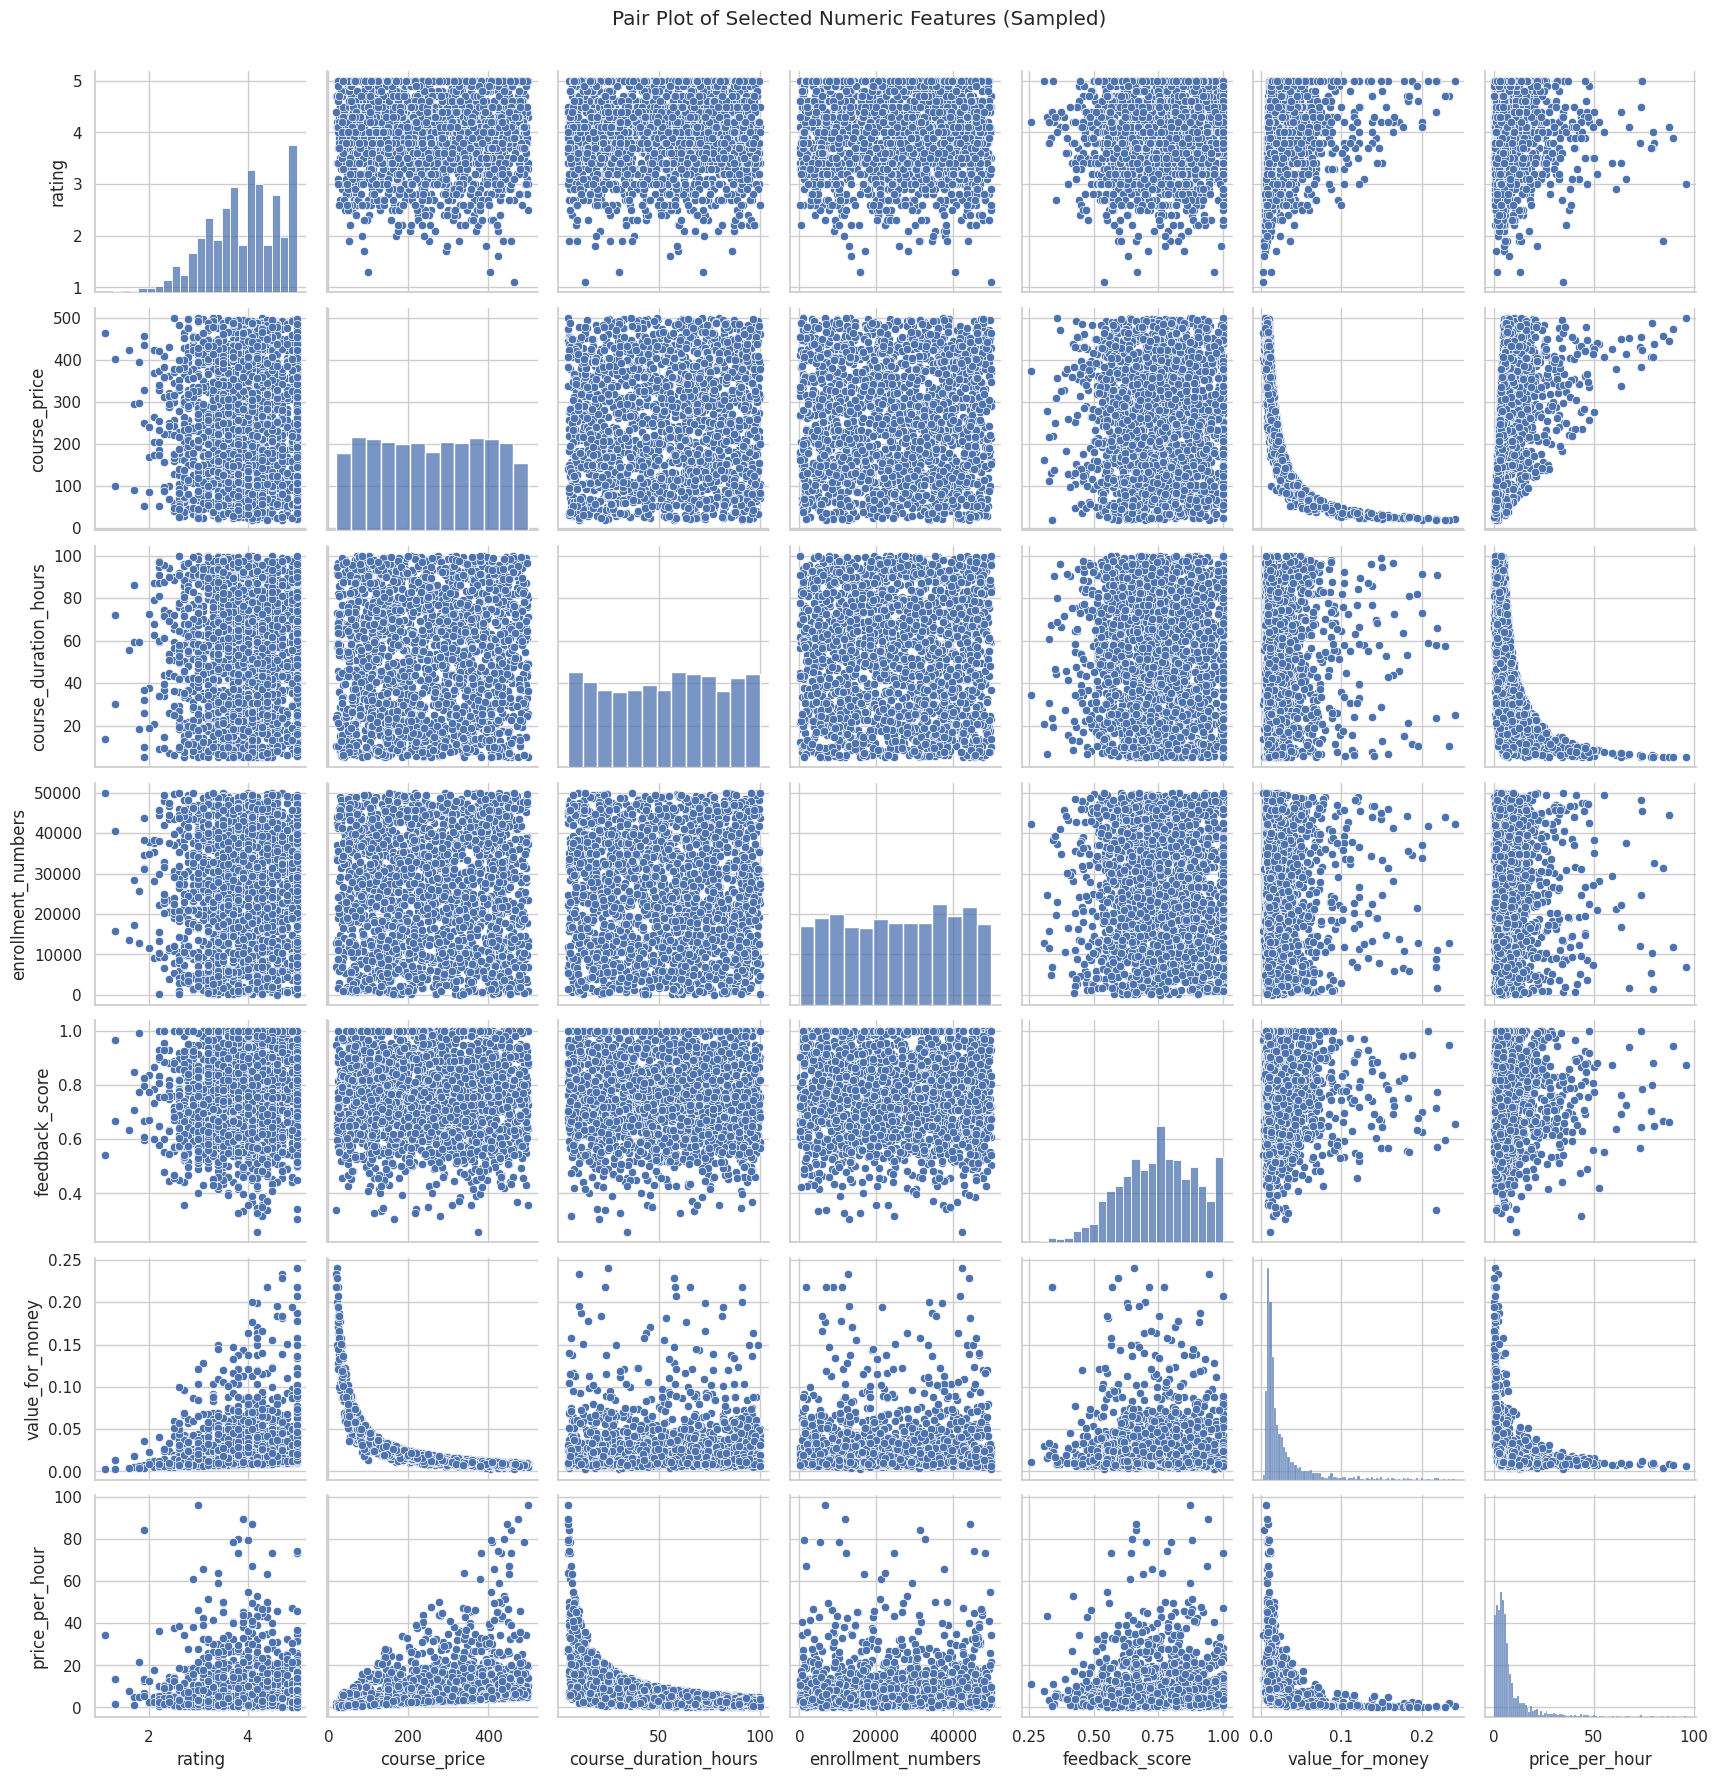

In [22]:
# 7. PAIR PLOT (MULTIVARIATE RELATIONSHIPS)

# Use a subset of numeric columns to avoid heavy plot
pairplot_cols = [
    "rating",
    "course_price",
    "course_duration_hours",
    "enrollment_numbers",
    "feedback_score",
    "value_for_money",
    "price_per_hour"
]

# Sample to reduce plotting load
df_sample = df[pairplot_cols].sample(n=2000, random_state=42)

sns.pairplot(df_sample)
plt.suptitle("Pair Plot of Selected Numeric Features (Sampled)", y=1.02)
plt.show()


=== ADVANCED EDA VISUALIZATIONS ===



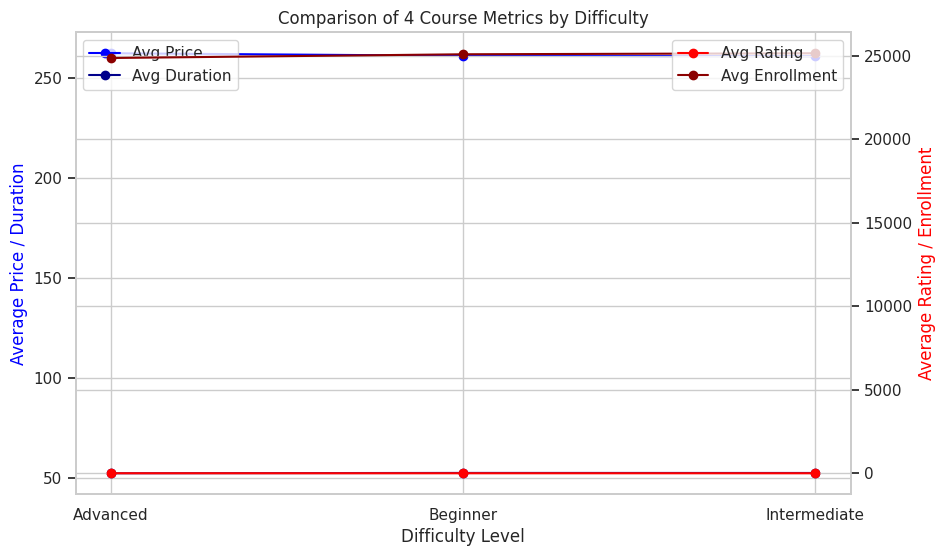

In [23]:

# ADVANCED EDA (  MULTI-COMPARISON)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("\n=== ADVANCED EDA VISUALIZATIONS ===\n")

#  MULTI-COMPARISON CHART (4 metrics)


df_group = df.groupby("difficulty_level").agg({
    "course_price": "mean",
    "course_duration_hours": "mean",
    "rating": "mean",
    "enrollment_numbers": "mean"
}).reset_index()

fig, ax1 = plt.subplots()

ax1.set_title("Comparison of 4 Course Metrics by Difficulty")
ax1.set_xlabel("Difficulty Level")
ax1.set_ylabel("Average Price / Duration", color="blue")

ax1.plot(df_group["difficulty_level"], df_group["course_price"], marker='o', label="Avg Price", color="blue")
ax1.plot(df_group["difficulty_level"], df_group["course_duration_hours"], marker='o', label="Avg Duration", color="darkblue")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.set_ylabel("Average Rating / Enrollment", color="red")
ax2.plot(df_group["difficulty_level"], df_group["rating"], marker='o', label="Avg Rating", color="red")
ax2.plot(df_group["difficulty_level"], df_group["enrollment_numbers"], marker='o', label="Avg Enrollment", color="darkred")
ax2.legend(loc="upper right")

plt.show()

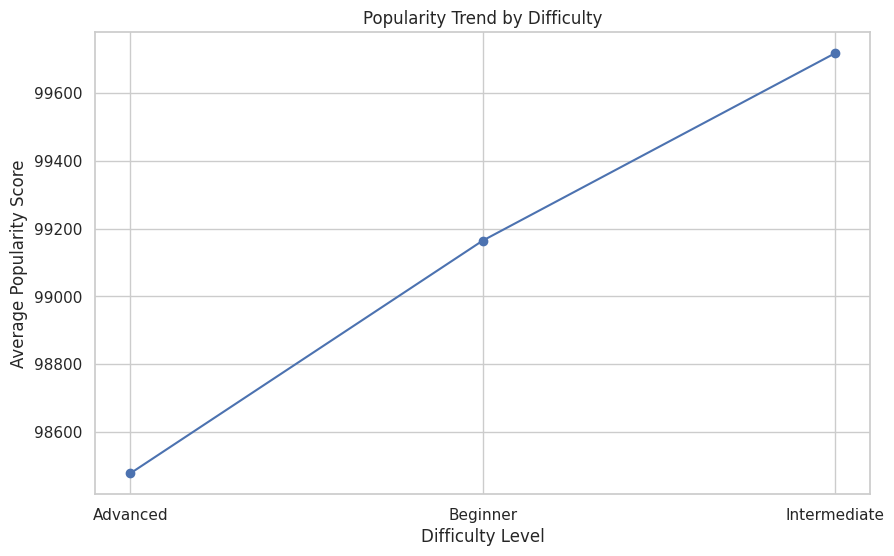

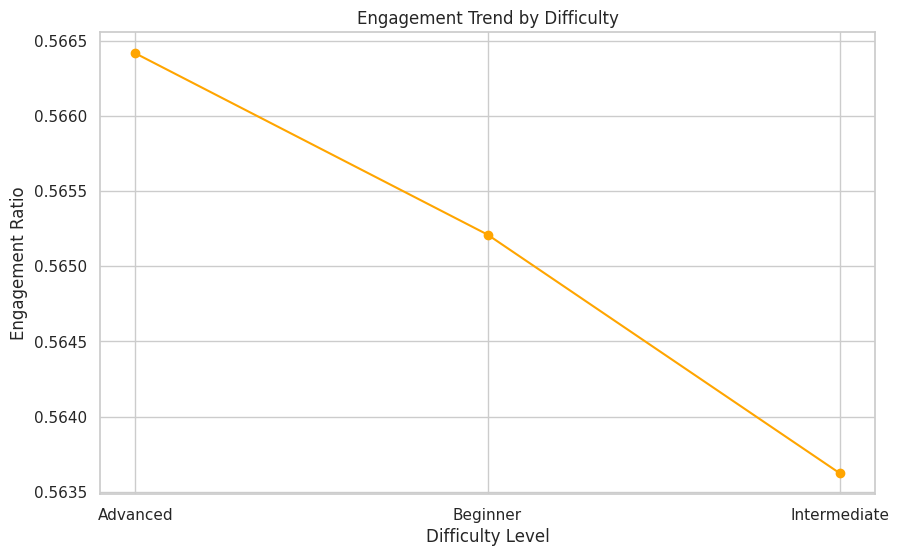

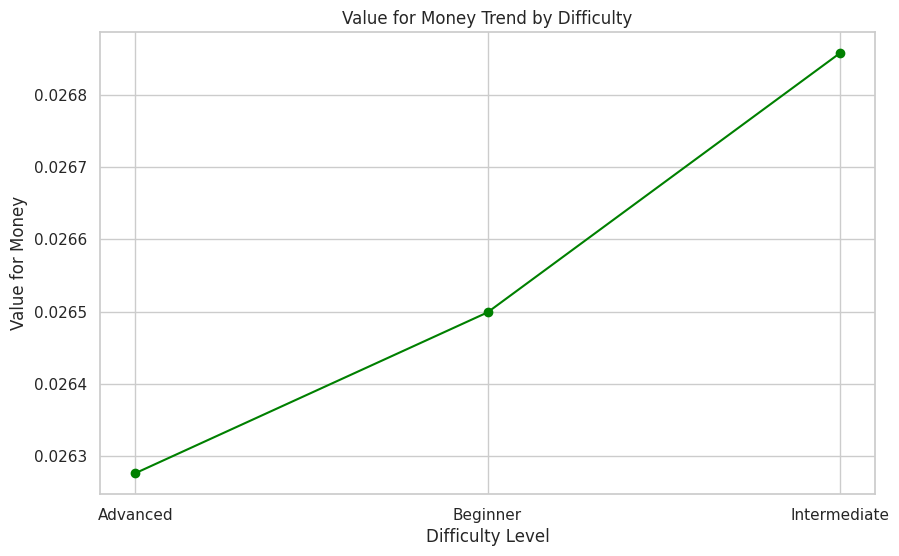

In [24]:
#  LINE CHARTS (TREND ANALYSIS)

trend_df = df.groupby("difficulty_level").agg({
    "popularity_score": "mean",
    "engagement_ratio": "mean",
    "value_for_money": "mean"
}).reset_index()

plt.plot(trend_df["difficulty_level"], trend_df["popularity_score"], marker='o')
plt.title("Popularity Trend by Difficulty")
plt.xlabel("Difficulty Level")
plt.ylabel("Average Popularity Score")
plt.show()

plt.plot(trend_df["difficulty_level"], trend_df["engagement_ratio"], marker='o', color='orange')
plt.title("Engagement Trend by Difficulty")
plt.xlabel("Difficulty Level")
plt.ylabel("Engagement Ratio")
plt.show()

plt.plot(trend_df["difficulty_level"], trend_df["value_for_money"], marker='o', color='green')
plt.title("Value for Money Trend by Difficulty")
plt.xlabel("Difficulty Level")
plt.ylabel("Value for Money")
plt.show()

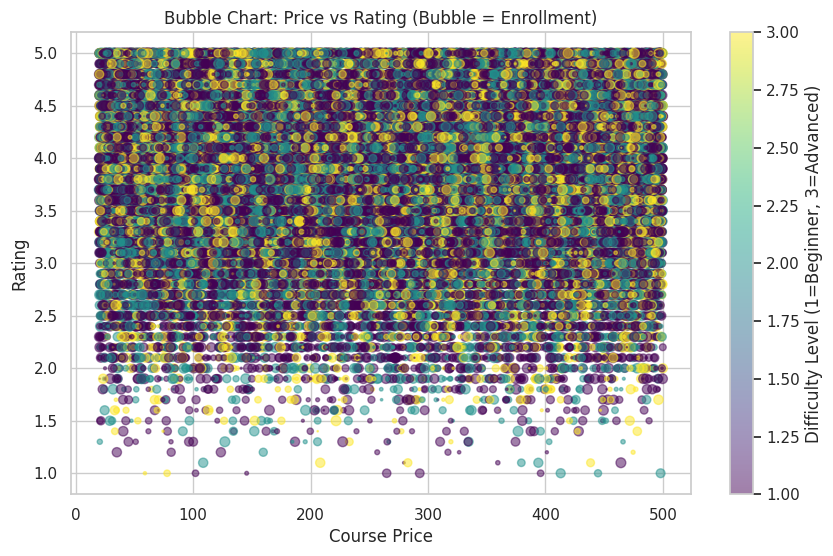

In [25]:
#  BUBBLE CHART (PRICE vs RATING vs ENROLLMENT)


plt.scatter(
    df["course_price"], df["rating"],
    s=df["enrollment_numbers"] / 1000,  # bubble size
    c=df["difficulty_level_ord"], cmap="viridis", alpha=0.5
)
plt.colorbar(label="Difficulty Level (1=Beginner, 3=Advanced)")
plt.title("Bubble Chart: Price vs Rating (Bubble = Enrollment)")
plt.xlabel("Course Price")
plt.ylabel("Rating")
plt.show()

In [26]:
#  RADAR PLOT: Compare Two Courses

def radar_plot(course1, course2):
    cols = ["course_price", "course_duration_hours", "rating", "feedback_score", "enrollment_numbers"]

    data1 = df[df["course_name"] == course1][cols].mean()
    data2 = df[df["course_name"] == course2][cols].mean()

    combined = pd.DataFrame([data1, data2])
    norm = (combined - combined.min()) / (combined.max() - combined.min())

    v1 = norm.iloc[0].values
    v2 = norm.iloc[1].values

    labels = np.array(cols)
    angles = np.linspace(0, 2 * np.pi, len(cols), endpoint=False)

    v1 = np.concatenate((v1, [v1[0]]))
    v2 = np.concatenate((v2, [v2[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)

    ax.plot(angles, v1, marker='o', label=course1)
    ax.fill(angles, v1, alpha=0.25)

    ax.plot(angles, v2, marker='o', label=course2)
    ax.fill(angles, v2, alpha=0.25)

    ax.set_thetagrids(angles[:-1] * 180 / np.pi, labels)
    plt.title("Course Comparison Radar Plot")
    plt.legend(loc="upper right")
    plt.show()

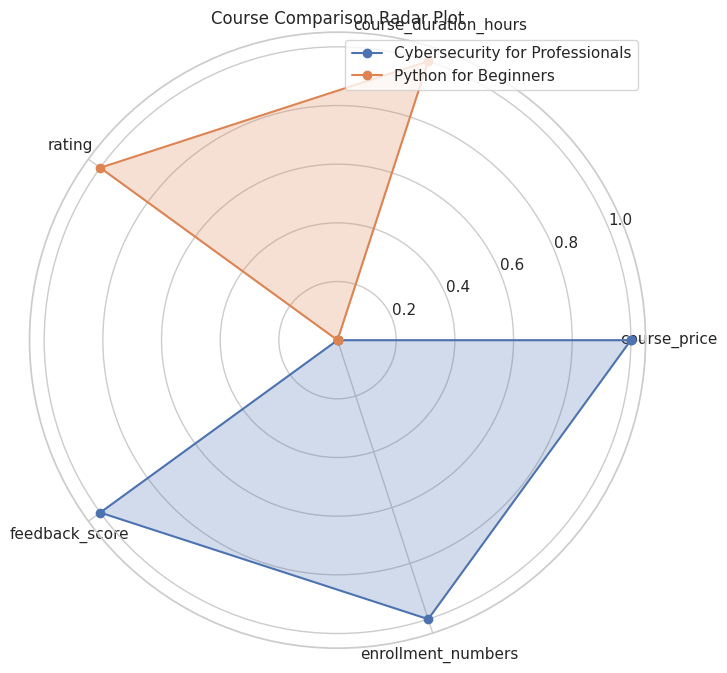

In [27]:
radar_plot("Cybersecurity for Professionals", "Python for Beginners")

In [28]:
#  MODEL Step-1 Train/Test split + user–item matrix
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import log2
import random

# 0) Split
ratings_df = df[["user_id", "course_id", "rating"]].copy()

train_df, test_df = train_test_split(
    ratings_df,
    test_size=0.2,
    random_state=42
)

print("Train rows:", len(train_df))
print("Test rows :", len(test_df))

# All course ids
all_items = df["course_id"].unique()

# User–item matrix from TRAIN
user_item = train_df.pivot_table(
    index="user_id",
    columns="course_id",
    values="rating"
).fillna(0.0)

print("User–Item shape:", user_item.shape)

Train rows: 79996
Test rows : 19999
User–Item shape: (39836, 9995)


In [29]:
# MODEL STEP2   Metric helpers (once, used by all models)
def precision_at_k(recommended, true_items, k):
    if not true_items:
        return None
    rec_k = recommended[:k]
    hits = len(set(rec_k) & true_items)
    return hits / k

def recall_at_k(recommended, true_items, k):
    if not true_items:
        return None
    rec_k = recommended[:k]
    hits = len(set(rec_k) & true_items)
    return hits / len(true_items)

def f1_at_k(prec, rec):
    if prec is None or rec is None or (prec + rec == 0):
        return None
    return 2 * prec * rec / (prec + rec)

def average_precision_at_k(recommended, true_items, k):
    if not true_items:
        return None
    score = 0.0
    hits = 0
    for i, item in enumerate(recommended[:k], start=1):
        if item in true_items:
            hits += 1
            score += hits / i
    if hits == 0:
        return 0.0
    return score / min(len(true_items), k)

def dcg_at_k(recommended, true_items, k):
    dcg = 0.0
    for i, item in enumerate(recommended[:k], start=1):
        rel = 1.0 if item in true_items else 0.0
        if rel > 0:
            dcg += rel / log2(i + 1)
    return dcg

def ndcg_at_k(recommended, true_items, k):
    if not true_items:
        return None
    dcg = dcg_at_k(recommended, true_items, k)
    ideal_rels = [1.0] * min(len(true_items), k)
    idcg = 0.0
    for i, rel in enumerate(ideal_rels, start=1):
        idcg += rel / log2(i + 1)
    if idcg == 0:
        return 0.0
    return dcg / idcg

def hit_rate_at_k(recommended, true_items, k):
    if not true_items:
        return None
    rec_k = recommended[:k]
    return 1.0 if len(set(rec_k) & true_items) > 0 else 0.0

In [30]:
# MODEL Step 3 Fast evaluation function
def evaluate_model_fast(model_name, predict_fn,
                        train_df, test_df, all_items,
                        K=10, max_users=150, neg_per_user=50):
    """
    predict_fn(user_id, course_id) -> predicted rating (float) or None
    Uses:
      - full test_df for RMSE/MAE
      - sampled users + sampled negatives for ranking metrics
    """

    # ---------- ERROR METRICS (RMSE, MAE) ----------
    y_true, y_pred = [], []

    for _, row in test_df.iterrows():
        uid = row["user_id"]
        cid = row["course_id"]
        true_r = row["rating"]

        pred_r = predict_fn(uid, cid)
        if pred_r is None:
            continue

        y_true.append(true_r)
        y_pred.append(pred_r)

    if y_true:
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae  = mean_absolute_error(y_true, y_pred)
    else:
        rmse, mae = None, None

    # ---------- RANKING METRICS (sampled users & items) ----------

    test_items_per_user = (
        test_df.groupby("user_id")["course_id"]
        .apply(set)
        .to_dict()
    )
    train_items_per_user = (
        train_df.groupby("user_id")["course_id"]
        .apply(set)
        .to_dict()
    )

    all_users = list(test_items_per_user.keys())
    random.shuffle(all_users)
    sampled_users = all_users[:min(max_users, len(all_users))]

    precisions, recalls, f1s = [], [], []
    maps, ndcgs, hit_rates = [], [], []
    all_rec_items = []

    for user_id in sampled_users:
        true_items = test_items_per_user[user_id]
        if not true_items:
            continue

        seen = train_items_per_user.get(user_id, set())
        remaining_items = [i for i in all_items if i not in seen]

        if not remaining_items:
            continue

        # sample negatives
        neg_sample = random.sample(
            remaining_items,
            k=min(neg_per_user, len(remaining_items))
        )

        candidate_items = list(true_items) + neg_sample

        scores = []
        for cid in candidate_items:
            s = predict_fn(user_id, cid)
            if s is not None:
                scores.append((cid, s))

        if not scores:
            continue

        scores.sort(key=lambda x: x[1], reverse=True)
        rec_list = [cid for (cid, _) in scores[:K]]

        all_rec_items.extend(rec_list)

        p  = precision_at_k(rec_list, true_items, K)
        r  = recall_at_k(rec_list, true_items, K)
        f  = f1_at_k(p, r)
        hr = hit_rate_at_k(rec_list, true_items, K)
        ap = average_precision_at_k(rec_list, true_items, K)
        nd = ndcg_at_k(rec_list, true_items, K)

        if p  is not None: precisions.append(p)
        if r  is not None: recalls.append(r)
        if f  is not None: f1s.append(f)
        if hr is not None: hit_rates.append(hr)
        if ap is not None: maps.append(ap)
        if nd is not None: ndcgs.append(nd)

    coverage = len(set(all_rec_items)) / len(all_items) if len(all_items) > 0 else 0.0

    metrics = {
        "model":       model_name,
        "precision@K": np.mean(precisions) if precisions else None,
        "recall@K":    np.mean(recalls)    if recalls    else None,
        "f1@K":        np.mean(f1s)        if f1s        else None,
        "MAP@K":       np.mean(maps)       if maps       else None,
        "NDCG@K":      np.mean(ndcgs)      if ndcgs      else None,
        "HitRate@K":   np.mean(hit_rates)  if hit_rates  else None,
        "Coverage":    coverage,
        "RMSE":        rmse,
        "MAE":         mae
    }

    print(f"\n===== {model_name} – METRICS =====")
    for k, v in metrics.items():
        print(f"{k}: {v}")

    return metrics

In [31]:
# MODEL STEP 4 CONTENT BASED FILERING


content_features = [
    "course_duration_hours","course_price","rating",
    "feedback_score","enrollment_numbers","time_spent_hours",
    "previous_courses_taken","difficulty_level_ord",
    "certification_offered_bin","study_material_available_bin",
    "price_per_hour","engagement_ratio","popularity_score",
    "value_for_money"
]

course_feats = df.groupby("course_id")[content_features].mean()

sim_content = pd.DataFrame(
    cosine_similarity(course_feats),
    index=course_feats.index,
    columns=course_feats.index
)

user_item_cont = user_item.copy()

def predict_content(user_id, course_id, k=20):
    if user_id not in user_item_cont.index:
        return None
    if course_id not in sim_content.index:
        return None

    user_ratings = user_item_cont.loc[user_id]      # ratings for TRAIN courses

    sims = sim_content.loc[course_id].reindex(user_ratings.index)

    mask = user_ratings != 0
    sims = sims[mask]
    rates = user_ratings[mask]

    if len(rates) == 0:
        return None

    sims_top = sims.sort_values(ascending=False).head(k)
    rates_top = rates[sims_top.index]

    denom = sims_top.abs().sum()
    if denom == 0:
        return None

    pred = float((sims_top * rates_top).sum() / denom)
    return pred

metrics_content = evaluate_model_fast(
    "Content-Based",
    predict_content,
    train_df,
    test_df,
    all_items,
    K=10,
    max_users=150,
    neg_per_user=50
)


===== Content-Based – METRICS =====
model: Content-Based
precision@K: 0.05932203389830507
recall@K: 0.4872881355932203
f1@K: 0.207405588761521
MAP@K: 0.28271455474845314
NDCG@K: 0.3340242578564362
HitRate@K: 0.5
Coverage: 0.10912182436487297
RMSE: 0.9338401283180204
MAE: 0.7502528837085738


In [32]:
#   Model 2   Collaborative Filtering (Item-CF)


item_rating_matrix = user_item.T  # items × users

sim_item = pd.DataFrame(
    cosine_similarity(item_rating_matrix),
    index=item_rating_matrix.index,
    columns=item_rating_matrix.index
)

def predict_itemcf(user_id, course_id, k=20):
    if user_id not in user_item.index:
        return None
    if course_id not in sim_item.index:
        return None

    user_ratings = user_item.loc[user_id]
    sims = sim_item.loc[course_id].reindex(user_ratings.index)

    mask = user_ratings != 0
    sims = sims[mask]
    rates = user_ratings[mask]

    if len(rates) == 0:
        return None

    sims_top = sims.sort_values(ascending=False).head(k)
    rates_top = rates[sims_top.index]

    denom = sims_top.abs().sum()
    if denom == 0:
        return None

    pred = float((sims_top * rates_top).sum() / denom)
    return pred

metrics_itemcf = evaluate_model_fast(
    "ItemCF",
    predict_itemcf,
    train_df,
    test_df,
    all_items,
    K=10,
    max_users=150,
    neg_per_user=50
)


===== ItemCF – METRICS =====
model: ItemCF
precision@K: 0.007692307692307693
recall@K: 0.02564102564102564
f1@K: 0.15384615384615383
MAP@K: 0.02564102564102564
NDCG@K: 0.036098363540212036
HitRate@K: 0.07692307692307693
Coverage: 0.0015003000600120023
RMSE: 1.0351151697439982
MAE: 0.8268292682926829


In [33]:
# Model 3 – Hybrid (Content + CF)


alpha = 0.5  # weight for content-based, 0.5 for CF

def predict_hybrid(user_id, course_id):
    pc = predict_content(user_id, course_id)
    pi = predict_itemcf(user_id, course_id)

    if pc is None and pi is None:
        return None
    if pc is None:
        return pi
    if pi is None:
        return pc
    return alpha * pc + (1 - alpha) * pi

metrics_hybrid = evaluate_model_fast(
    "Hybrid",
    predict_hybrid,
    train_df,
    test_df,
    all_items,
    K=10,
    max_users=150,
    neg_per_user=50
)


===== Hybrid – METRICS =====
model: Hybrid
precision@K: 0.058870967741935475
recall@K: 0.45564516129032256
f1@K: 0.21210178710178712
MAP@K: 0.28510304659498203
NDCG@K: 0.3301201525057661
HitRate@K: 0.4838709677419355
Coverage: 0.11502300460092019
RMSE: 0.9338695333164172
MAE: 0.7502592638334288


In [34]:
results_df = pd.DataFrame([ metrics_content, metrics_itemcf, metrics_hybrid ])

print("\n===== FINAL COMPARISON =====")
print(results_df[[ "model","precision@K","recall@K","f1@K", "MAP@K","NDCG@K","HitRate@K","Coverage", "RMSE","MAE" ]])


===== FINAL COMPARISON =====
           model  precision@K  recall@K      f1@K     MAP@K    NDCG@K  \
0  Content-Based     0.059322  0.487288  0.207406  0.282715  0.334024   
1         ItemCF     0.007692  0.025641  0.153846  0.025641  0.036098   
2         Hybrid     0.058871  0.455645  0.212102  0.285103  0.330120   

   HitRate@K  Coverage      RMSE       MAE  
0   0.500000  0.109122  0.933840  0.750253  
1   0.076923  0.001500  1.035115  0.826829  
2   0.483871  0.115023  0.933870  0.750259  


In [35]:
# Normalized metrics + best model per metric

# -----------------------------------
# 0) Inspect structure (optional)
# -----------------------------------
print("Index:", results_df.index.tolist())
print("Columns:", results_df.columns.tolist())

# -----------------------------------
# 1) Ensure we have a model index
# -----------------------------------
if "model" in results_df.columns:
    # Case A: you have a 'model' column
    results_metrics = results_df.set_index("model", drop=True).copy()
else:
    # Case B: model names are already the index
    results_metrics = results_df.copy()
    # If index is just 0,1,2,... give them names manually
    if all(isinstance(i, (int, np.integer)) for i in results_metrics.index):
        # You can adjust these:
        results_metrics.index = ["Content-Based", "ItemCF", "Hybrid"]

print("\n=== METRIC TABLE USED FOR ANALYSIS ===")
print(results_metrics)

# -----------------------------------
# 2) Metric directions
# -----------------------------------
metric_directions = {
    "precision@K": "max",
    "recall@K": "max",
    "f1@K": "max",
    "MAP@K": "max",
    "NDCG@K": "max",
    "HitRate@K": "max",
    "Coverage": "max",
    "RMSE": "min",   # lower is better
    "MAE": "min"     # lower is better
}

# Keep only metrics that actually exist
metric_directions = {
    m: d for m, d in metric_directions.items()
    if m in results_metrics.columns
}

# -----------------------------------
# 3) Best model per metric
# -----------------------------------
rows = []
for metric, direction in metric_directions.items():
    col = results_metrics[metric].astype(float)
    if direction == "max":
        best_model = col.idxmax()
    else:
        best_model = col.idxmin()
    rows.append({
        "metric": metric,
        "direction": "higher is better" if direction == "max" else "lower is better",
        "best_model": best_model,
        "best_value": col[best_model]
    })

best_by_metric_df = pd.DataFrame(rows).sort_values("metric")

print("\n=== BEST MODEL PER METRIC ===")
print(best_by_metric_df)

# -----------------------------------
# 4) Metric wins per model
# -----------------------------------
win_counts = (
    best_by_metric_df["best_model"]
    .value_counts()
    .rename("metric_wins")
    .reset_index()
    .rename(columns={"index": "model"})
)

print("\n=== METRIC WINS PER MODEL ===")
print(win_counts)

Index: [0, 1, 2]
Columns: ['model', 'precision@K', 'recall@K', 'f1@K', 'MAP@K', 'NDCG@K', 'HitRate@K', 'Coverage', 'RMSE', 'MAE']

=== METRIC TABLE USED FOR ANALYSIS ===
               precision@K  recall@K      f1@K     MAP@K    NDCG@K  HitRate@K  \
model                                                                           
Content-Based     0.059322  0.487288  0.207406  0.282715  0.334024   0.500000   
ItemCF            0.007692  0.025641  0.153846  0.025641  0.036098   0.076923   
Hybrid            0.058871  0.455645  0.212102  0.285103  0.330120   0.483871   

               Coverage      RMSE       MAE  
model                                        
Content-Based  0.109122  0.933840  0.750253  
ItemCF         0.001500  1.035115  0.826829  
Hybrid         0.115023  0.933870  0.750259  

=== BEST MODEL PER METRIC ===
        metric         direction     best_model  best_value
6     Coverage  higher is better         Hybrid    0.115023
5    HitRate@K  higher is better  Content-B


=== METRIC WINS PER MODEL ===


best_model  metric_wins
0  Content-Based            6
1         Hybrid            3

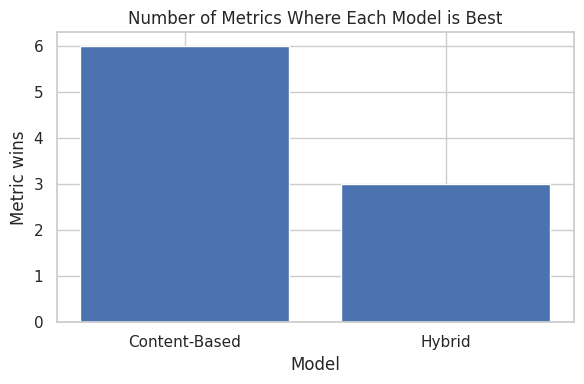

In [36]:

print("\n=== METRIC WINS PER MODEL ===")
display(win_counts)
plt.figure(figsize=(6, 4))
plt.bar(win_counts["best_model"], win_counts["metric_wins"])
plt.title("Number of Metrics Where Each Model is Best")
plt.xlabel("Model")
plt.ylabel("Metric wins")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [37]:
!ls -lah /content

total 8.6M
drwxr-xr-x 1 root root 4.0K Dec  8 11:02 .
drwxr-xr-x 1 root root 4.0K Dec  8 11:01 ..
drwxr-xr-x 4 root root 4.0K Nov 20 14:30 .config
-rw-r--r-- 1 root root 8.6M Dec  8 11:03 online_course_recommendation_v2.xlsx
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data


In [38]:
 import pickle
from pathlib import Path
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# COLAB CONFIG

BASE_DIR = Path("/content")
INPUT_EXCEL = BASE_DIR / "online_course_recommendation_v2.xlsx"
ARTIFACTS_PATH = BASE_DIR / "artifacts"
ARTIFACTS_PATH.mkdir(parents=True, exist_ok=True)

# CHANGE THESE IF YOUR COLUMNS HAVE DIFFERENT NAMES
USER_COL = "user_id"
ITEM_COL = "course_id"
RATING_COL = "rating"   # if not present in Excel, we'll treat all interactions as 1

In [39]:

#  LOAD DATA

print("Loading Excel from:", INPUT_EXCEL)
df = pd.read_excel(INPUT_EXCEL)
print("Columns:", df.columns.tolist())
print(df.head())

Loading Excel from: /content/online_course_recommendation_v2.xlsx
Columns: ['user_id', 'course_id', 'course_name', 'instructor', 'course_duration_hours', 'certification_offered', 'difficulty_level', 'rating', 'enrollment_numbers', 'course_price', 'feedback_score', 'study_material_available', 'time_spent_hours', 'previous_courses_taken']
   user_id  course_id                       course_name       instructor  \
0    15796       9366              Python for Beginners      Emma Harris   
1      861       1928   Cybersecurity for Professionals  Alexander Young   
2    38159       9541  DevOps and Continuous Deployment   Dr. Mia Walker   
3    44733       3708   Project Management Fundamentals   Benjamin Lewis   
4    11285       3361       Ethical Hacking Masterclass     Daniel White   

   course_duration_hours certification_offered difficulty_level  rating  \
0                   39.1                   Yes         Beginner     5.0   
1                   36.3                   Yes        

In [40]:

#  BUILD MAPPINGS

user_ids = df[USER_COL].astype(str).unique()
item_ids = df[ITEM_COL].astype(str).unique()

user2idx = {u: i for i, u in enumerate(user_ids)}
idx2user = {i: u for u, i in user2idx.items()}

item2idx = {it: j for j, it in enumerate(item_ids)}
idx2item = {j: it for it, j in item2idx.items()}

print(f"Users: {len(user2idx)}, Items: {len(item2idx)}")

Users: 43242, Items: 9998


In [41]:

# 3. BUILD USER–ITEM MATRIX
rows = df[USER_COL].astype(str).map(user2idx)
cols = df[ITEM_COL].astype(str).map(item2idx)

if RATING_COL in df.columns:
    vals = df[RATING_COL].astype(float)
else:
    vals = np.ones(len(df), dtype=float)

n_users = len(user2idx)
n_items = len(item2idx)

user_item_sparse = csr_matrix((vals, (rows, cols)), shape=(n_users, n_items))
user_item = user_item_sparse.toarray()   # small/medium → okay to convert to dense

print("user_item shape:", user_item.shape)

user_item shape: (43242, 9998)


In [42]:
# 4. COMPUTE SIMILARITIES

item_sim_cf = cosine_similarity(user_item_sparse.T)
item_sim_content = item_sim_cf.copy()   # placeholder; later you can replace with real content

In [43]:
#  SAVE ARTIFACTS

artifacts = {
    "user2idx": user2idx,
    "idx2user": idx2user,
    "item2idx": item2idx,
    "idx2item": idx2item,
}

with open(ARTIFACTS_PATH / "mappings.pkl", "wb") as f:
    pickle.dump(artifacts, f)

np.save(ARTIFACTS_PATH / "user_item.npy", user_item)
np.save(ARTIFACTS_PATH / "item_sim_cf.npy", item_sim_cf)
np.save(ARTIFACTS_PATH / "item_sim_content.npy", item_sim_content)

print(" Artifacts saved in:", ARTIFACTS_PATH)

 Artifacts saved in: /content/artifacts


In [44]:
!ls -lah /content/artifacts

total 4.8G
drwxr-xr-x 2 root root 4.0K Dec  8 11:15 .
drwxr-xr-x 1 root root 4.0K Dec  8 11:10 ..
-rw-r--r-- 1 root root 763M Dec  8 11:15 item_sim_cf.npy
-rw-r--r-- 1 root root 763M Dec  8 11:16 item_sim_content.npy
-rw-r--r-- 1 root root 967K Dec  8 11:10 mappings.pkl
-rw-r--r-- 1 root root 3.3G Dec  8 11:14 user_item.npy


In [46]:
from google.colab import files

files.download('/content/artifacts/mappings.pkl')
files.download('/content/artifacts/user_item.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install streamlit

In [ ]:
import streamlit as st

In [ ]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from scipy.sparse import csr_matrix, save_npz

# ======================
# CONFIG
# ======================
BASE_DIR = Path("/content")
INPUT_EXCEL = BASE_DIR / "online_course_recommendation_v2.xlsx"
ARTIFACTS_PATH = BASE_DIR / "artifacts_light"
ARTIFACTS_PATH.mkdir(parents=True, exist_ok=True)

USER_COL = "user_id"
ITEM_COL = "course_id"
RATING_COL = "rating"   # if not present, we use implicit 1


# ======================
# 1. LOAD DATA
# ======================
print("Loading Excel...")
df = pd.read_excel(INPUT_EXCEL)
print("Original shape:", df.shape)
print("Columns:", df.columns.tolist())

# ======================
# 2. SUBSET (to keep artifacts small)
# ======================
# Top N items by popularity
TOP_ITEMS = 1000   # you can adjust
item_counts = df[ITEM_COL].value_counts()
top_items = item_counts.head(TOP_ITEMS).index

df_small = df[df[ITEM_COL].isin(top_items)].copy()

# Optional: also limit users to those who interacted most
TOP_USERS = 5000
user_counts = df_small[USER_COL].value_counts()
top_users = user_counts.head(TOP_USERS).index

df_small = df_small[df_small[USER_COL].isin(top_users)].copy()

print("Reduced shape:", df_small.shape)

# ======================
# 3. BUILD MAPPINGS
# ======================
user_ids = df_small[USER_COL].astype(str).unique()
item_ids = df_small[ITEM_COL].astype(str).unique()

user2idx = {u: i for i, u in enumerate(user_ids)}
idx2user = {i: u for u, i in user2idx.items()}

item2idx = {it: j for j, it in enumerate(item_ids)}
idx2item = {j: it for it, j in item2idx.items()}

print(f"Users (subset): {len(user2idx)}, Items (subset): {len(item2idx)}")

# ======================
# 4. BUILD SPARSE USER–ITEM MATRIX
# ======================
rows = df_small[USER_COL].astype(str).map(user2idx)
cols = df_small[ITEM_COL].astype(str).map(item2idx)

if RATING_COL in df_small.columns:
    vals = df_small[RATING_COL].astype(float)
else:
    vals = np.ones(len(df_small), dtype=float)

n_users = len(user2idx)
n_items = len(item2idx)

user_item = csr_matrix((vals, (rows, cols)), shape=(n_users, n_items))

print("user_item shape:", user_item.shape)
print("user_item nnz (non-zeros):", user_item.nnz)

# ======================
# 5. SAVE ARTIFACTS (LIGHT)
# ======================
artifacts = {
    "user2idx": user2idx,
    "idx2user": idx2user,
    "item2idx": item2idx,
    "idx2item": idx2item,
}

with open(ARTIFACTS_PATH / "mappings.pkl", "wb") as f:
    pickle.dump(artifacts, f)

save_npz(ARTIFACTS_PATH / "user_item.npz", user_item)

print(" Light artifacts saved in:", ARTIFACTS_PATH)


In [ ]:
!ls -lah /content/artifacts_light

In [ ]:
from google.colab import files

files.download('/content/online_course_recommendation_v2.xlsx')
files.download('/content/artifacts_light/mappings.pkl')
files.download('/content/artifacts_light/user_item.npz')

In [ ]:
st.write("BASE_DIR:", BASE_DIR)
st.write("ARTIFACTS_PATH:", ARTIFACTS_PATH)
st.write("Files in ARTIFACTS_PATH:", list(ARTIFACTS_PATH.glob("*")))

In [ ]:
@st.cache_resource
def load_artifacts():
    st.write("BASE_DIR:", BASE_DIR)
    st.write("ARTIFACTS_PATH:", ARTIFACTS_PATH)
    st.write("Exists?", ARTIFACTS_PATH.exists())
    st.write("Is dir?", ARTIFACTS_PATH.is_dir())
    st.write("Contents:", list(ARTIFACTS_PATH.glob("*")))

    with open(ARTIFACTS_PATH / "mappings.pkl", "rb") as f:
        maps = pickle.load(f)
    ...

In [ ]:
import os

# Root folder for your repo
root = "/content/online_course_recsys"

# Create main structure
os.makedirs(f"{root}/artifacts", exist_ok=True)
os.makedirs(f"{root}/data", exist_ok=True)

print("Folders created:")
!tree /content/online_course_recsys

In [ ]:
!cp /content/artifacts_light/mappings.pkl /content/online_course_recsys/artifacts/
!cp /content/artifacts_light/user_item.npz /content/online_course_recsys/artifacts/

In [ ]:
!tree /content/online_course_recsys

In [ ]:
app_code = r"""
import streamlit as st
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from scipy.sparse import load_npz

# PATHS
BASE_DIR = Path(__file__).resolve().parent
ARTIFACTS_PATH = BASE_DIR / "artifacts"
DATA_PATH = BASE_DIR / "data"

EXCEL_PATH = DATA_PATH / "online_course_recommendation_v2.xlsx"


@st.cache_resource
def load_artifacts():
    with open(ARTIFACTS_PATH / "mappings.pkl", "rb") as f:
        maps = pickle.load(f)
    user2idx = maps["user2idx"]
    idx2user = maps["idx2user"]
    item2idx = maps["item2idx"]
    idx2item = maps["idx2item"]

    user_item = load_npz(ARTIFACTS_PATH / "user_item.npz")
    return user2idx, idx2user, item2idx, idx2item, user_item


@st.cache_resource
def load_courses():
    if EXCEL_PATH.exists():
        return pd.read_excel(EXCEL_PATH)
    return None


def recommend_for_user_simple(user_id, top_k, user2idx, idx2item, user_item, courses_df=None):
    user_id = str(user_id)
    if user_id not in user2idx:
        return pd.DataFrame(columns=["course_id", "score"])

    uidx = user2idx[user_id]
    user_row = user_item[uidx]
    interacted = set(user_row.indices)

    popularity = np.array(user_item.sum(axis=0)).ravel()
    popularity[list(interacted)] = -np.inf

    top_idx = np.argsort(popularity)[::-1][:top_k]
    top_items = [idx2item[i] for i in top_idx]
    top_scores = popularity[top_idx]

    df = pd.DataFrame({"course_id": top_items, "score": top_scores})

    if courses_df is not None and "course_id" in courses_df.columns:
        df = df.merge(courses_df, on="course_id", how="left")
    return df


def main():
    st.title("  Online Course Recommendation System")

    user2idx, idx2user, item2idx, idx2item, user_item = load_artifacts()
    courses_df = load_courses()

    st.sidebar.header("Settings")
    sample_users = list(user2idx.keys())

    mode = st.sidebar.radio("Input mode", ["Select user", "Type user"])

    if mode == "Select user" and sample_users:
        user_id = st.sidebar.selectbox("User ID", sample_users)
    else:
        user_id = st.sidebar.text_input("User ID")

    top_k = st.sidebar.slider("Number of recommendations", 5, 30, 10)

    if st.button("Recommend"):
        recs = recommend_for_user_simple(user_id, top_k, user2idx, idx2item, user_item, courses_df)
        if recs.empty:
            st.warning("No results (invalid user or no data).")
        else:
            st.dataframe(recs)


if __name__ == "__main__":
    main()
"""

with open("/content/online_course_recsys/app.py", "w") as f:
    f.write(app_code)

print("app.py created.")

In [ ]:
import os

root = "/content/online_course_recsys"

os.makedirs(f"{root}/artifacts", exist_ok=True)
os.makedirs(f"{root}/data", exist_ok=True)

print("Folders created!")
!ls -R /content/online_course_recsys

In [ ]:
app_code = r"""
import streamlit as st
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from scipy.sparse import load_npz

BASE_DIR = Path(__file__).resolve().parent
ARTIFACTS_PATH = BASE_DIR / "artifacts"
DATA_PATH = BASE_DIR / "data"

EXCEL_PATH = DATA_PATH / "online_course_recommendation_v2.xlsx"

@st.cache_resource
def load_artifacts():
    with open(ARTIFACTS_PATH / "mappings.pkl", "rb") as f:
        maps = pickle.load(f)
    user2idx = maps["user2idx"]
    idx2user = maps["idx2user"]
    item2idx = maps["item2idx"]
    idx2item = maps["idx2item"]

    user_item = load_npz(ARTIFACTS_PATH / "user_item.npz")
    return user2idx, idx2user, item2idx, idx2item, user_item


@st.cache_resource
def load_courses():
    if EXCEL_PATH.exists():
        return pd.read_excel(EXCEL_PATH)
    return None

def recommend_for_user_simple(user_id, top_k, user2idx, idx2item, user_item, courses_df=None):
    user_id = str(user_id)
    if user_id not in user2idx:
        return pd.DataFrame(columns=["course_id", "score"])

    uidx = user2idx[user_id]
    user_row = user_item[uidx]
    interacted = set(user_row.indices)

    popularity = np.array(user_item.sum(axis=0)).ravel()
    popularity[list(interacted)] = -np.inf

    top_idx = np.argsort(popularity)[::-1][:top_k]
    top_items = [idx2item[i] for i in top_idx]
    top_scores = popularity[top_idx]

    df = pd.DataFrame({"course_id": top_items, "score": top_scores})
    if courses_df is not None and "course_id" in courses_df.columns:
        df = df.merge(courses_df, on="course_id", how="left")
    return df

def main():
    st.title("  Online Course Recommendation System")

    user2idx, idx2user, item2idx, idx2item, user_item = load_artifacts()
    courses_df = load_courses()

    st.sidebar.header("Settings")
    sample_users = list(user2idx.keys())

    mode = st.sidebar.radio("Input mode", ["Select user", "Type user"])

    if mode == "Select user" and sample_users:
        user_id = st.sidebar.selectbox("User ID", sample_users)
    else:
        user_id = st.sidebar.text_input("User ID")

    top_k = st.sidebar.slider("Number of recommendations", 5, 30, 10)

    if st.button("Recommend"):
        recs = recommend_for_user_simple(user_id, top_k, user2idx, idx2item, user_item, courses_df)
        if recs.empty:
            st.warning("No results (invalid user or no data).")
        else:
            st.dataframe(recs)

if __name__ == "__main__":
    main()
"""

with open("/content/online_course_recsys/app.py", "w") as f:
    f.write(app_code)

print("app.py created!")
!ls /content/online_course_recsys